In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
from matplotlib import offsetbox
import sklearn
from sklearn import manifold
from sklearn.preprocessing import MinMaxScaler

In [3]:
dir_data = './donnees/'

In [4]:
x = np.loadtxt(dir_data+"x.txt")

In [7]:
print(x.shape)

(256, 480)


chaque colonne est un chiffre de 16*16=256

In [8]:
t = np.loadtxt(dir_data+"t.txt")


In [9]:
print(t.shape)

(10, 480)


In [10]:
t_label_num = np.where((t.T==1))[1]
class_label = ['zero','un','deux','trois','quatre','cinq','six','sept','huit','neuf']
t_label_str = [ class_label[i] for i in t_label_num]
print("Quelques colonnes de t.txt:\n",t[:,:3])

Quelques colonnes de t.txt:
 [[ 1. -1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1. -1.]]


X_data shape: (256, 480)
y_data shape: (10, 480)
hx_hy shape: (32, 480)
pg_pd shape: (32, 480)
hx_hy_pg_pd shape: (64, 480)
pb_ph shape: (32, 480)
hx_hy_pb_ph shape: (64, 480)


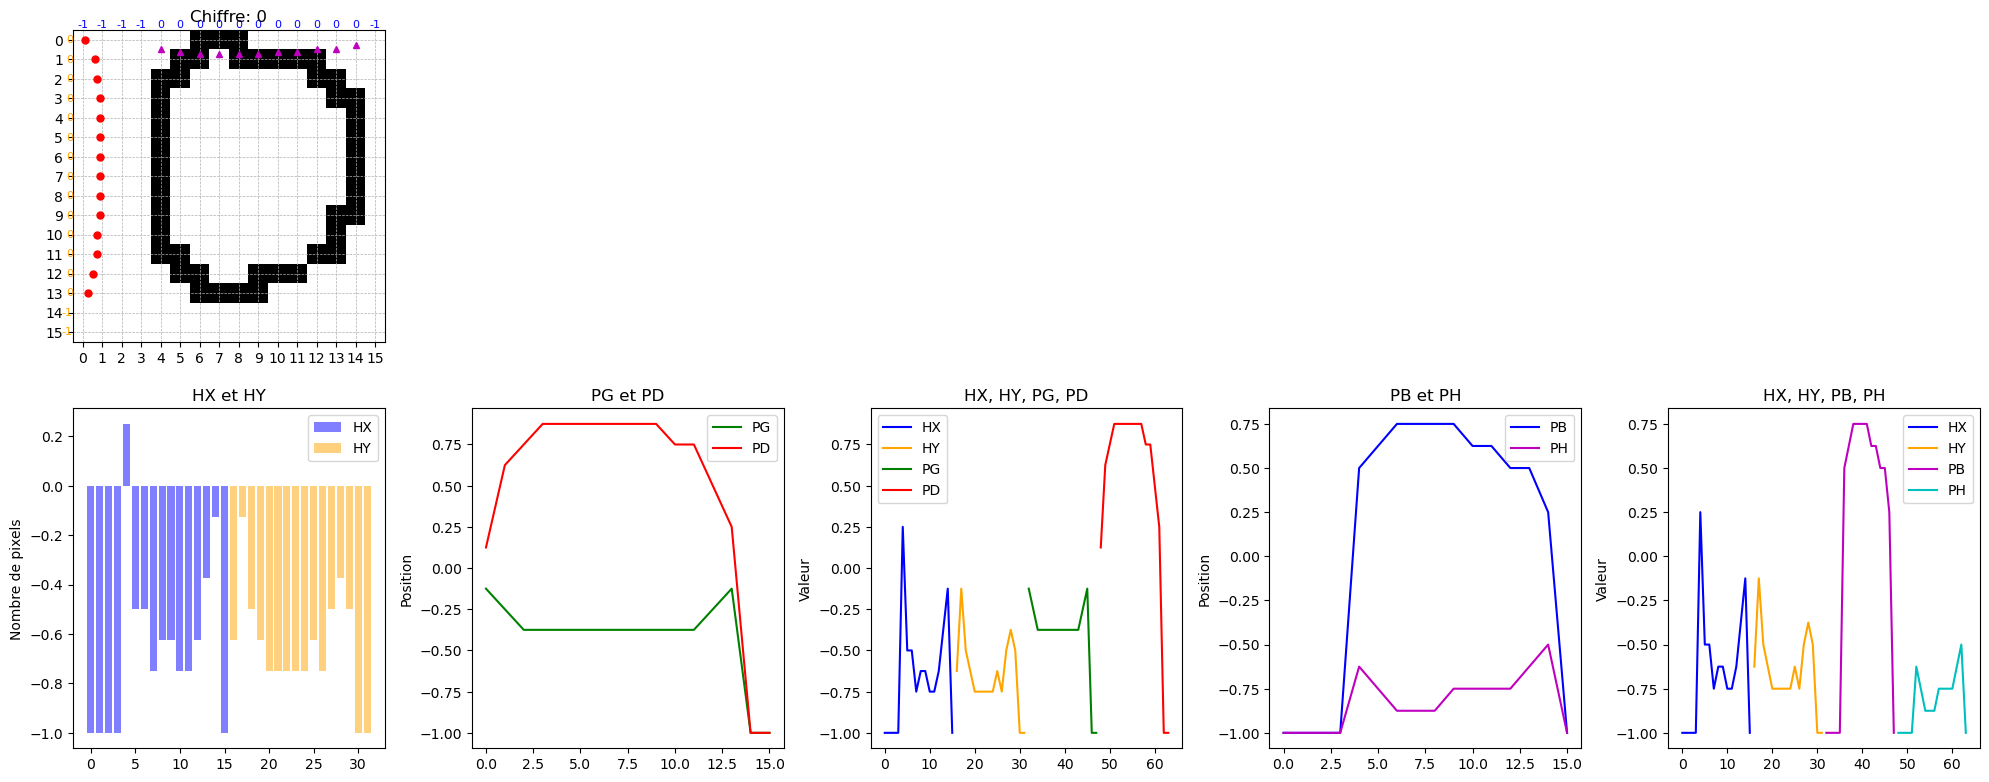

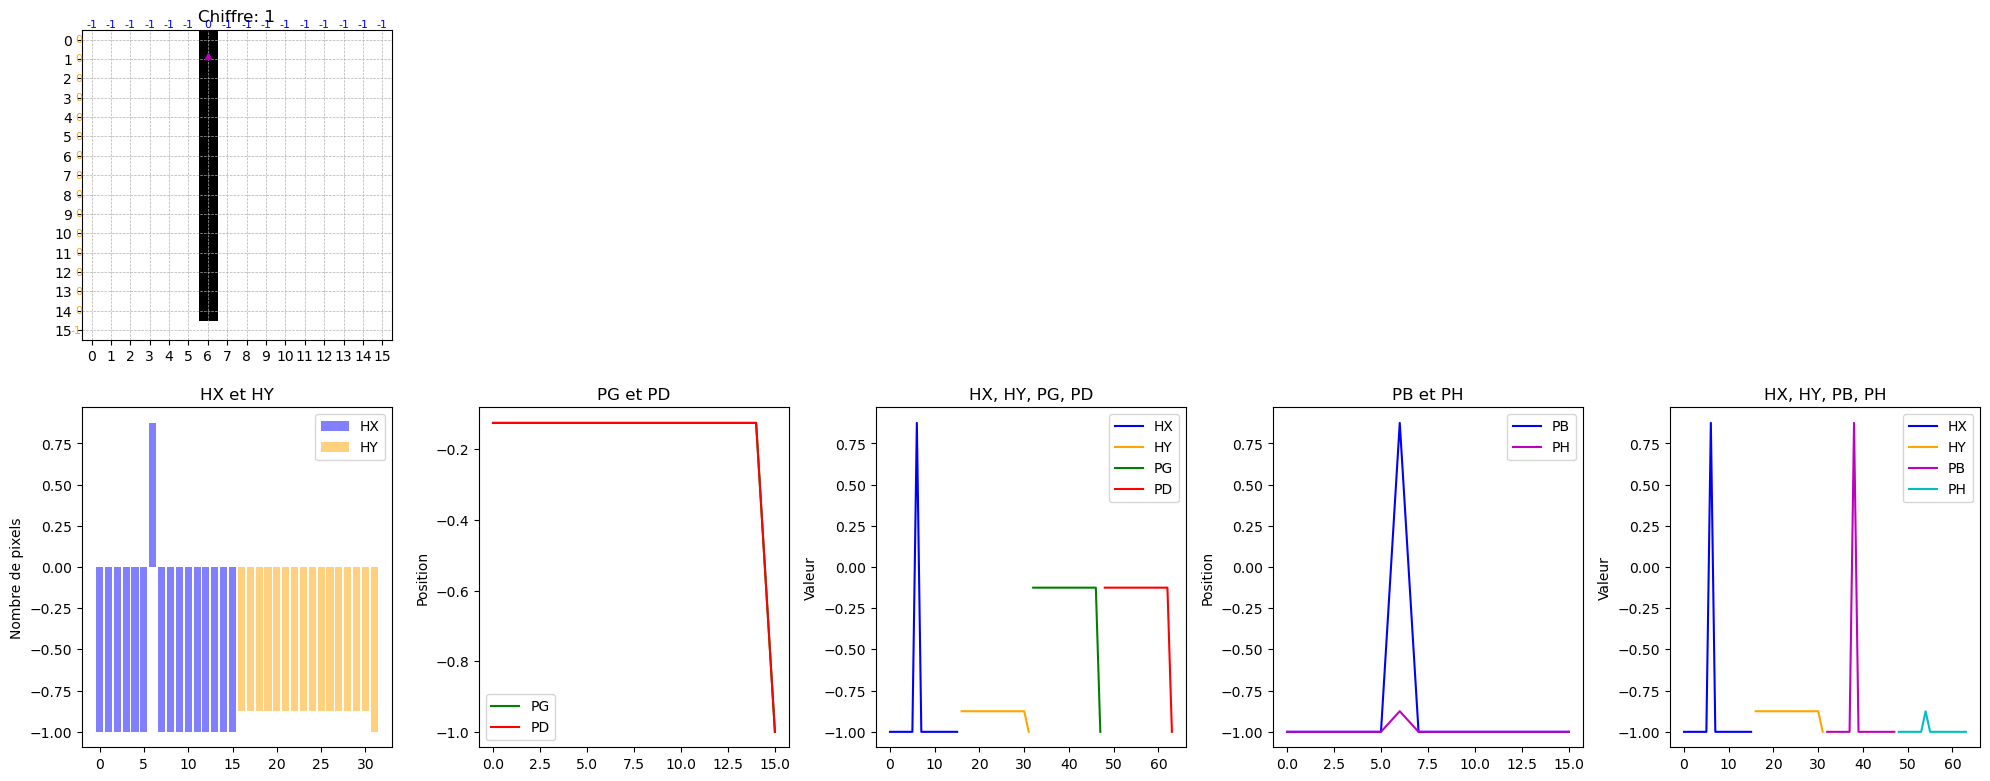

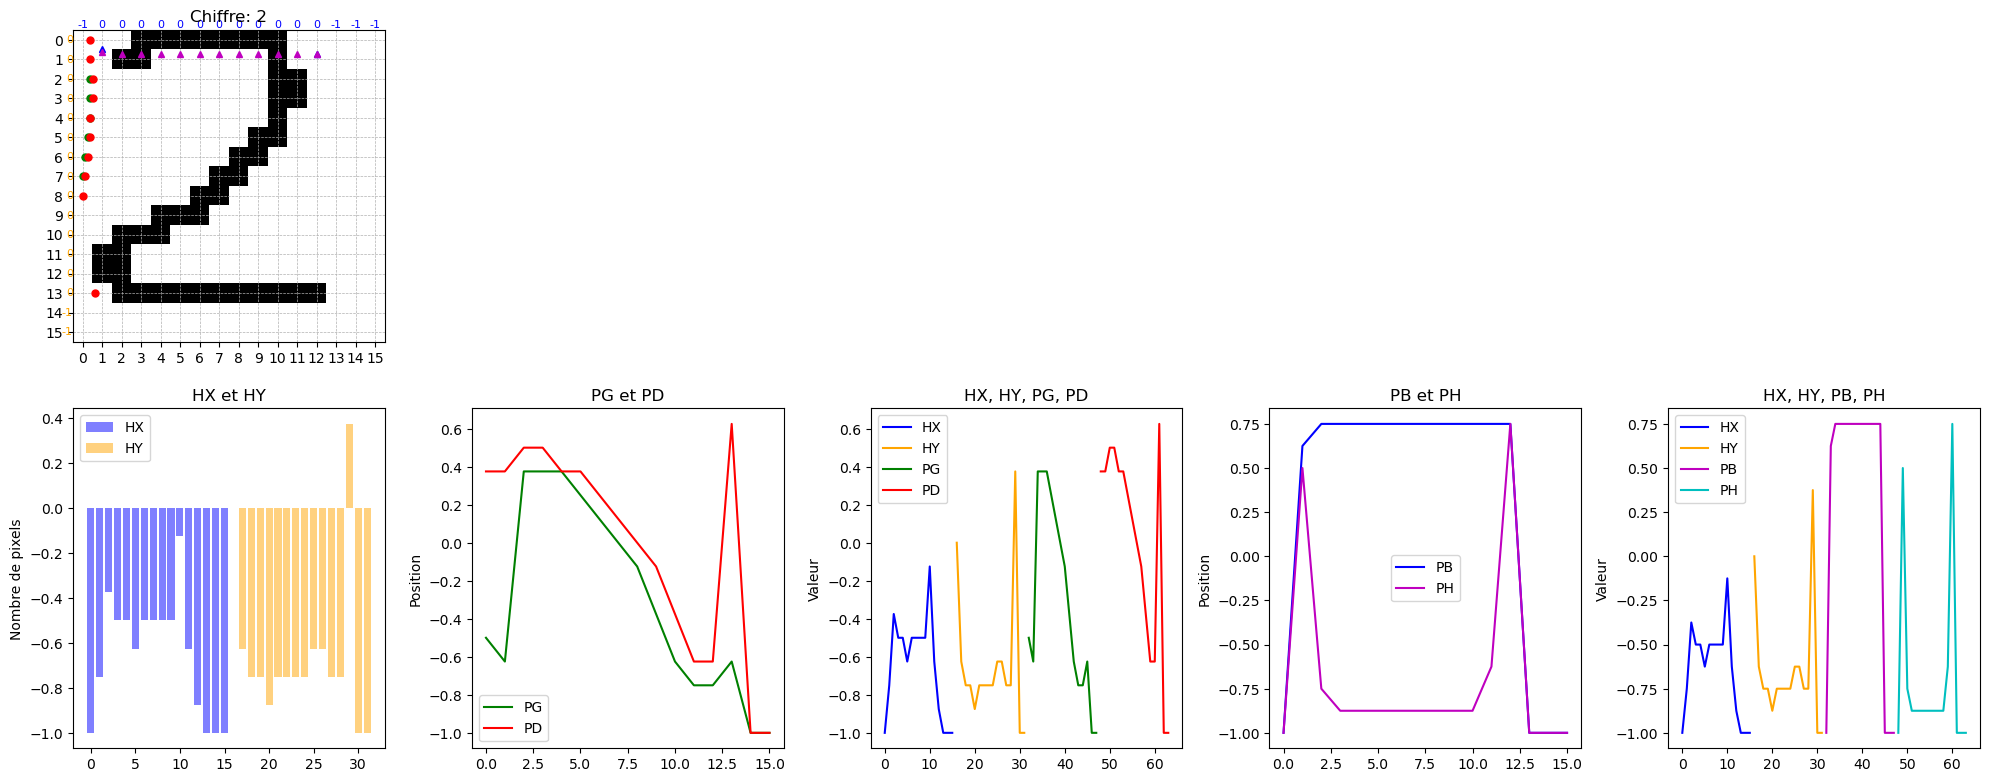

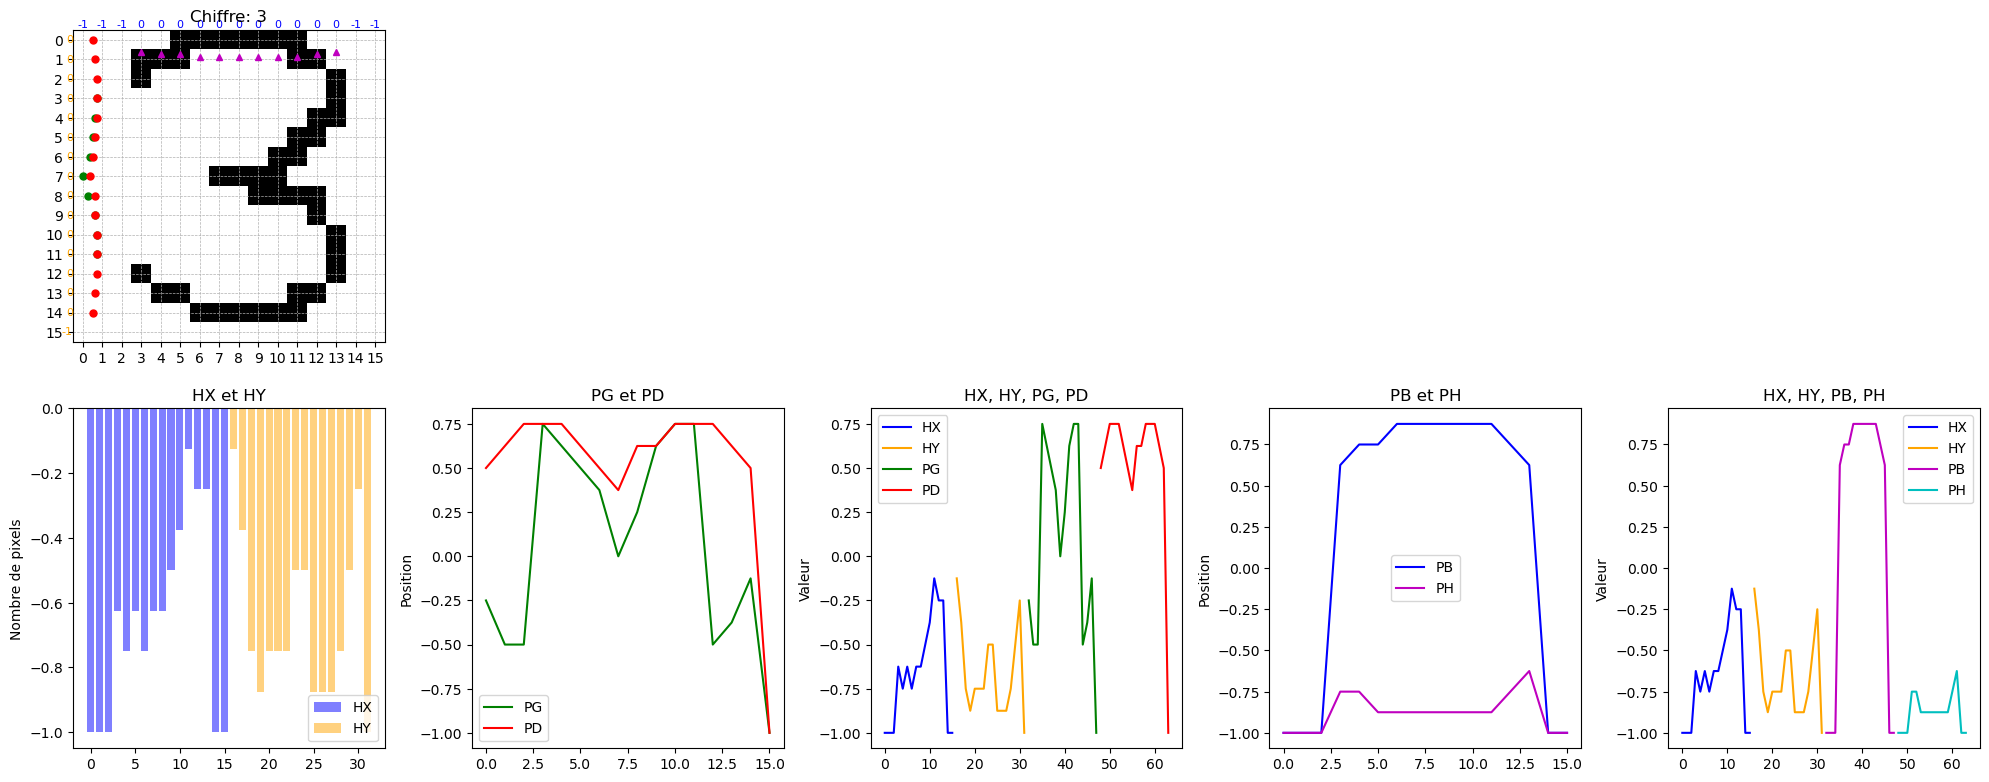

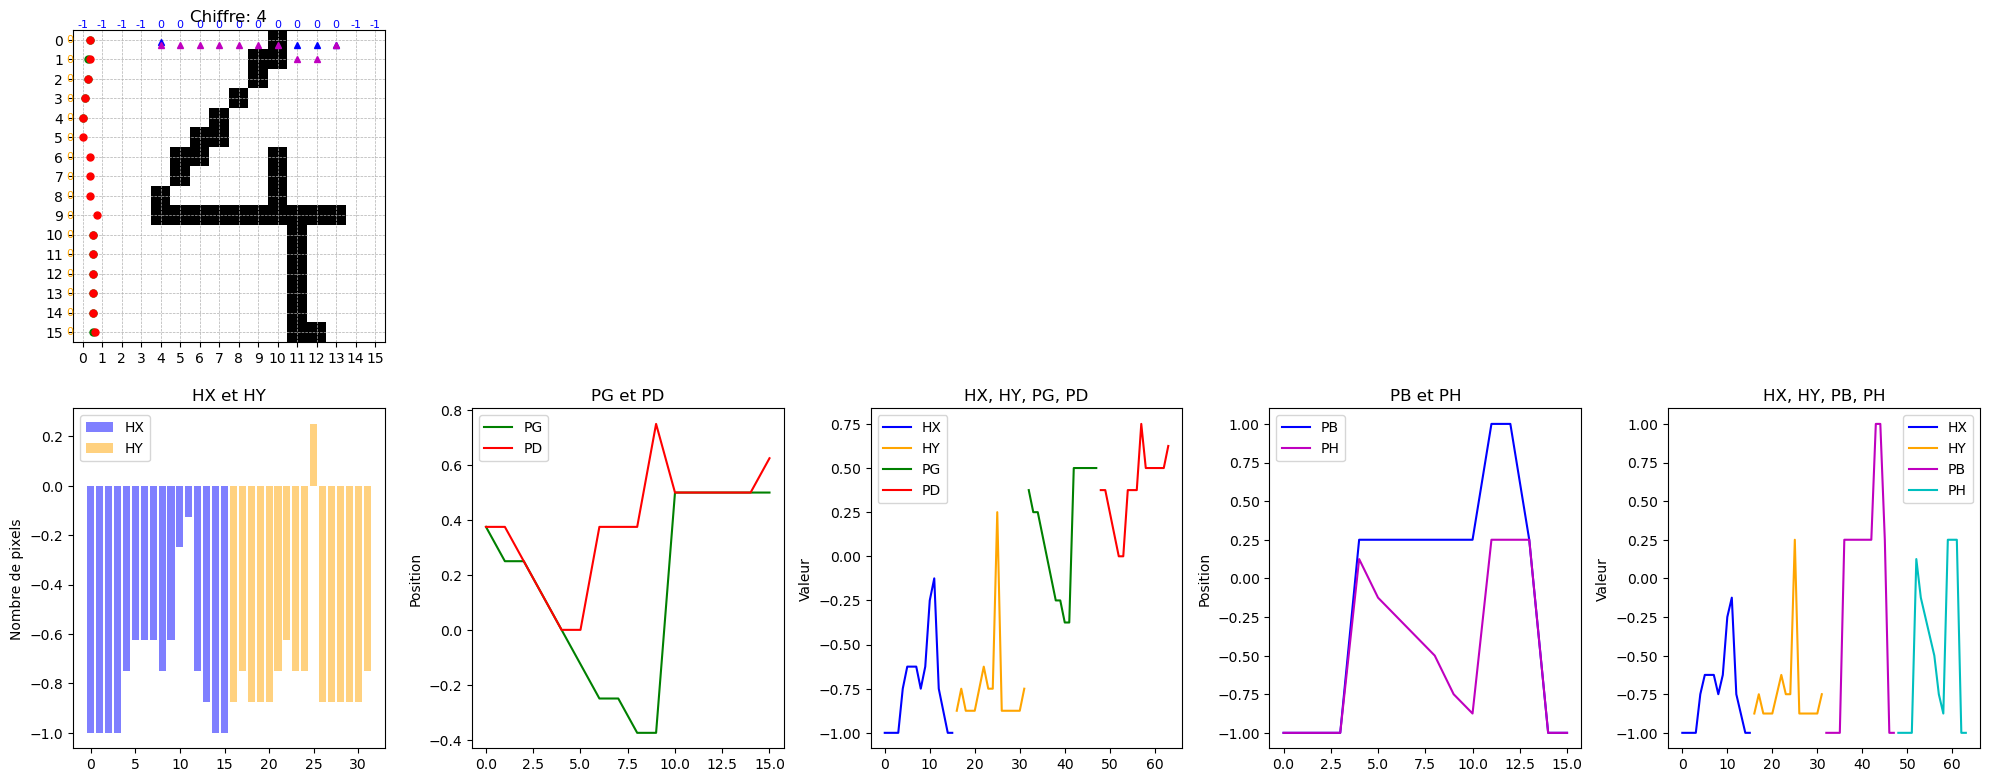

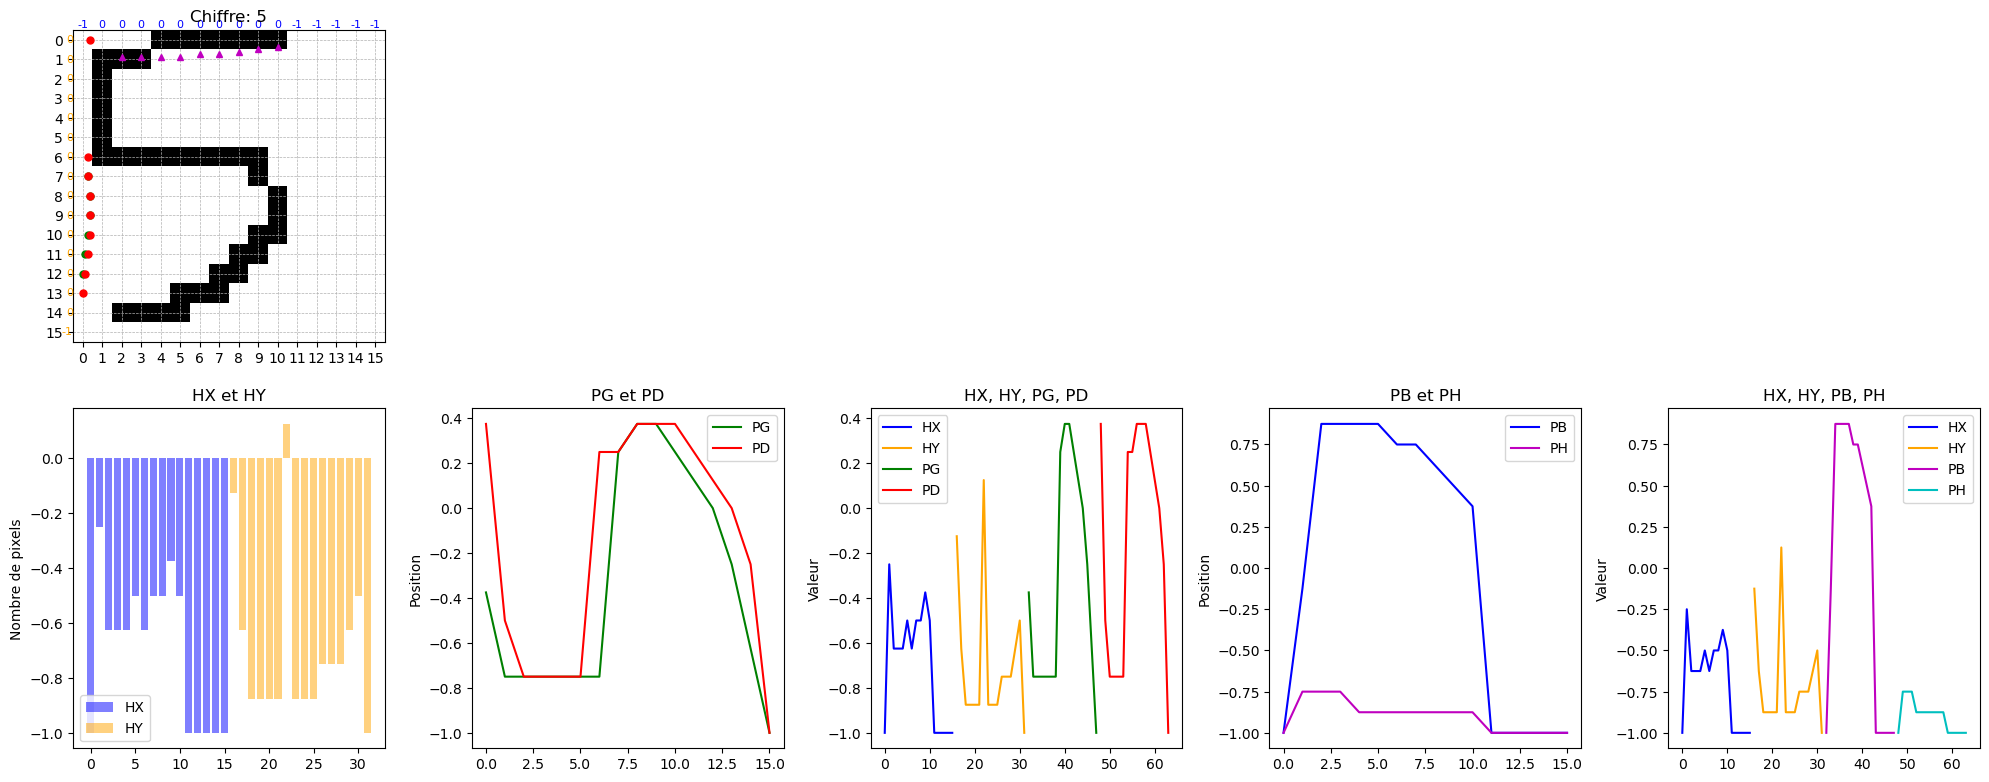

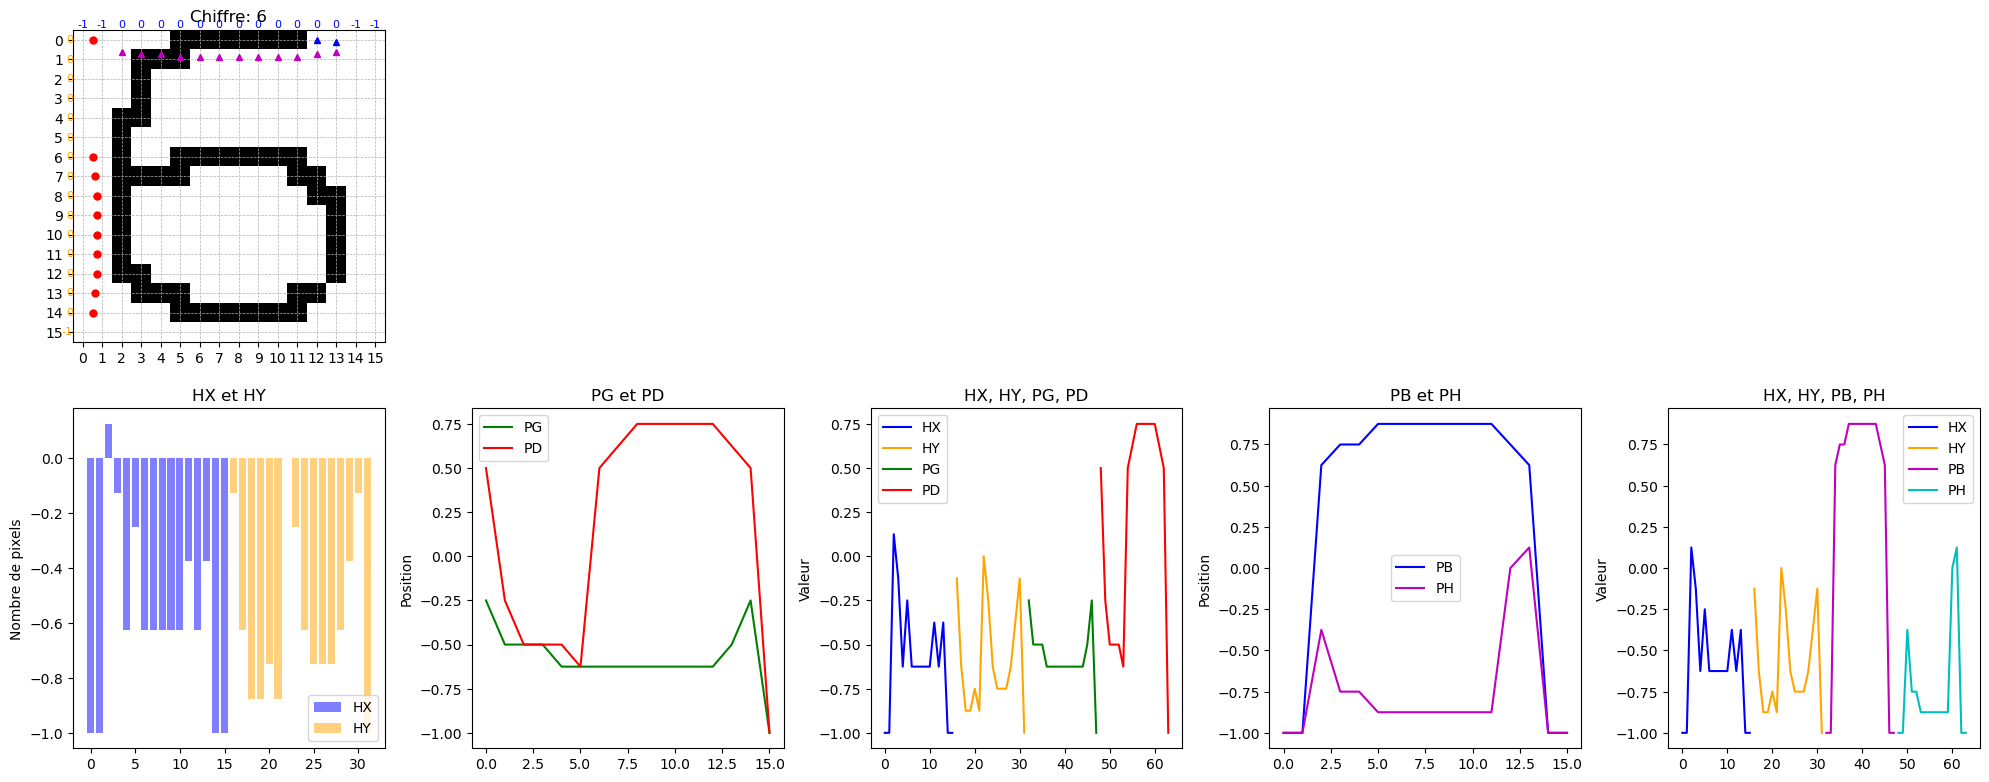

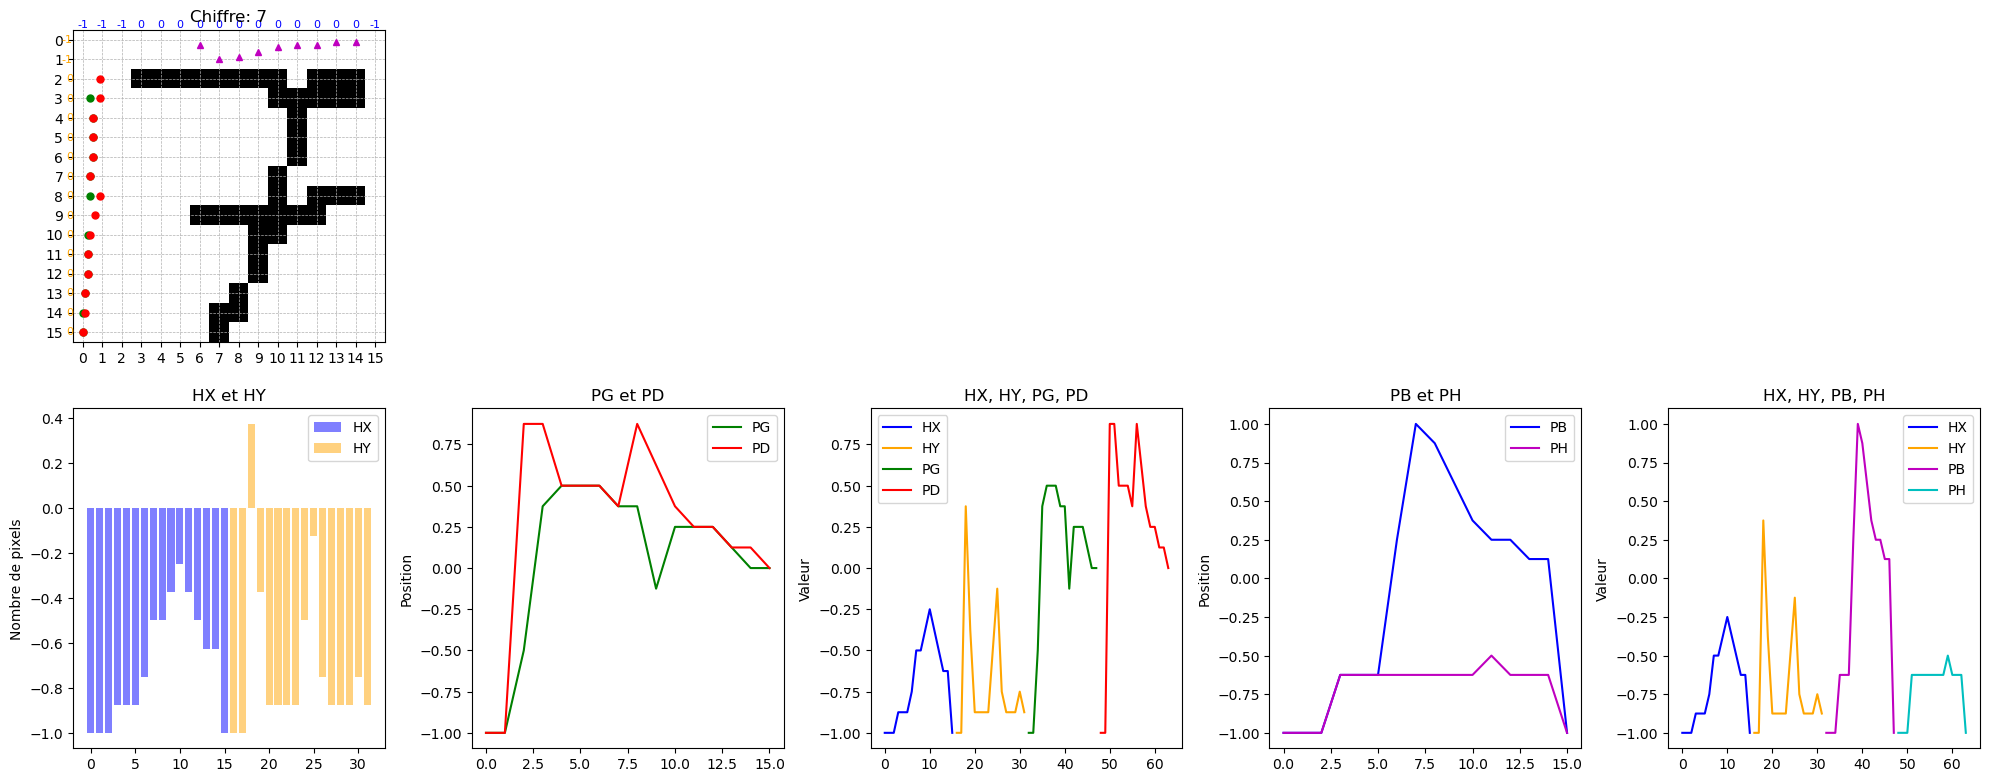

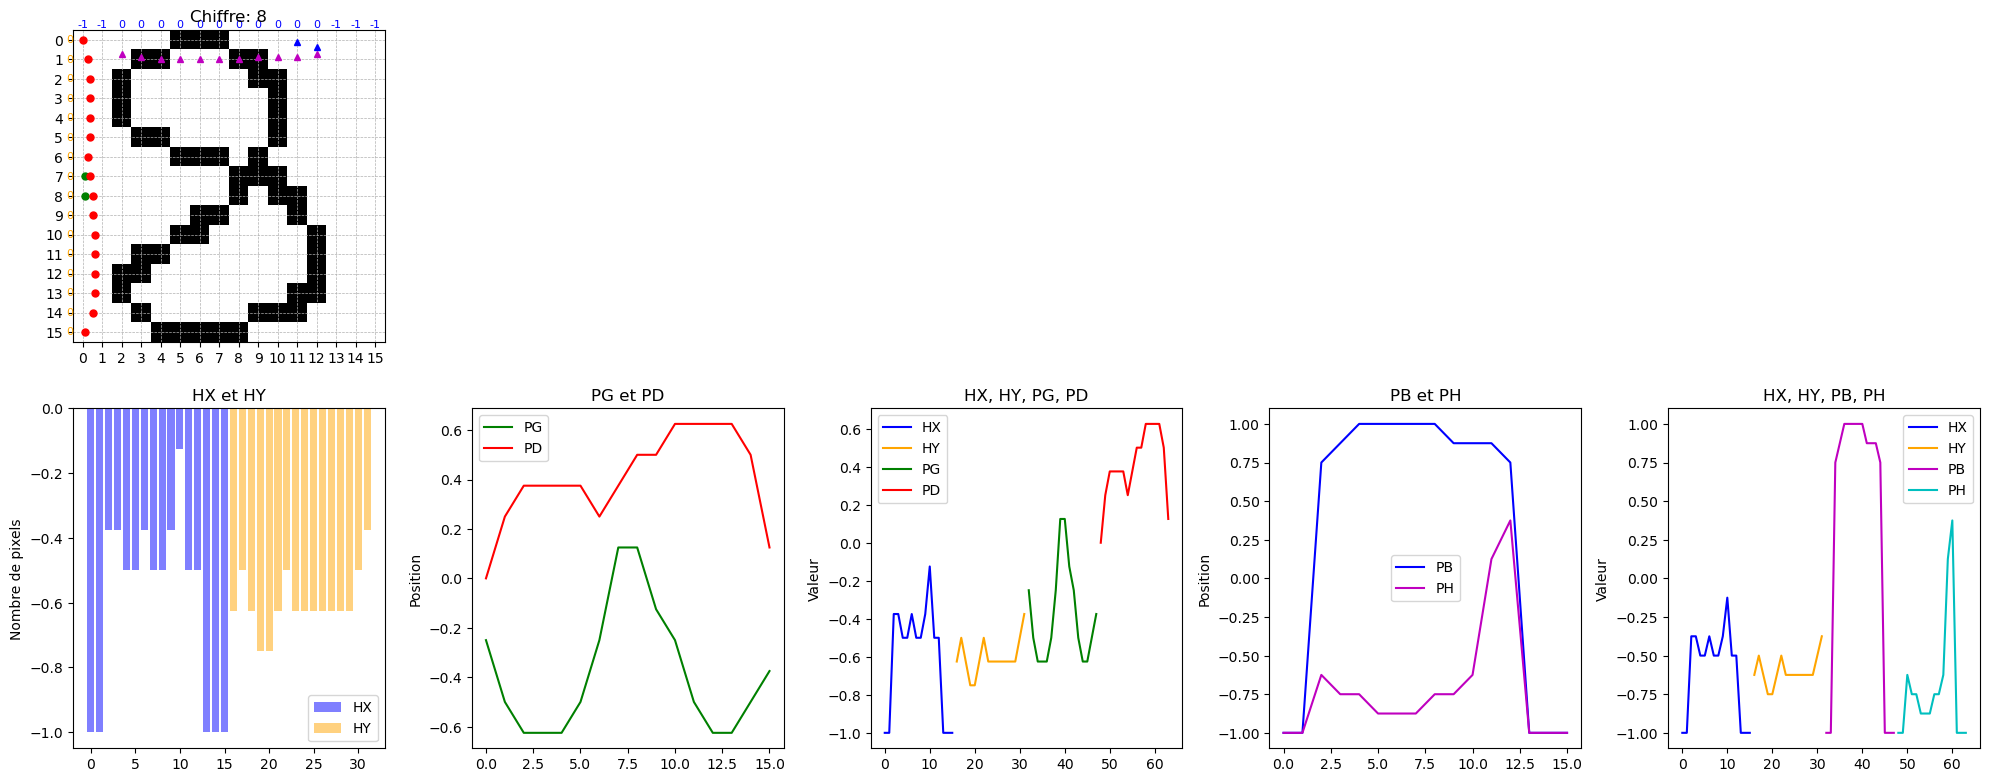

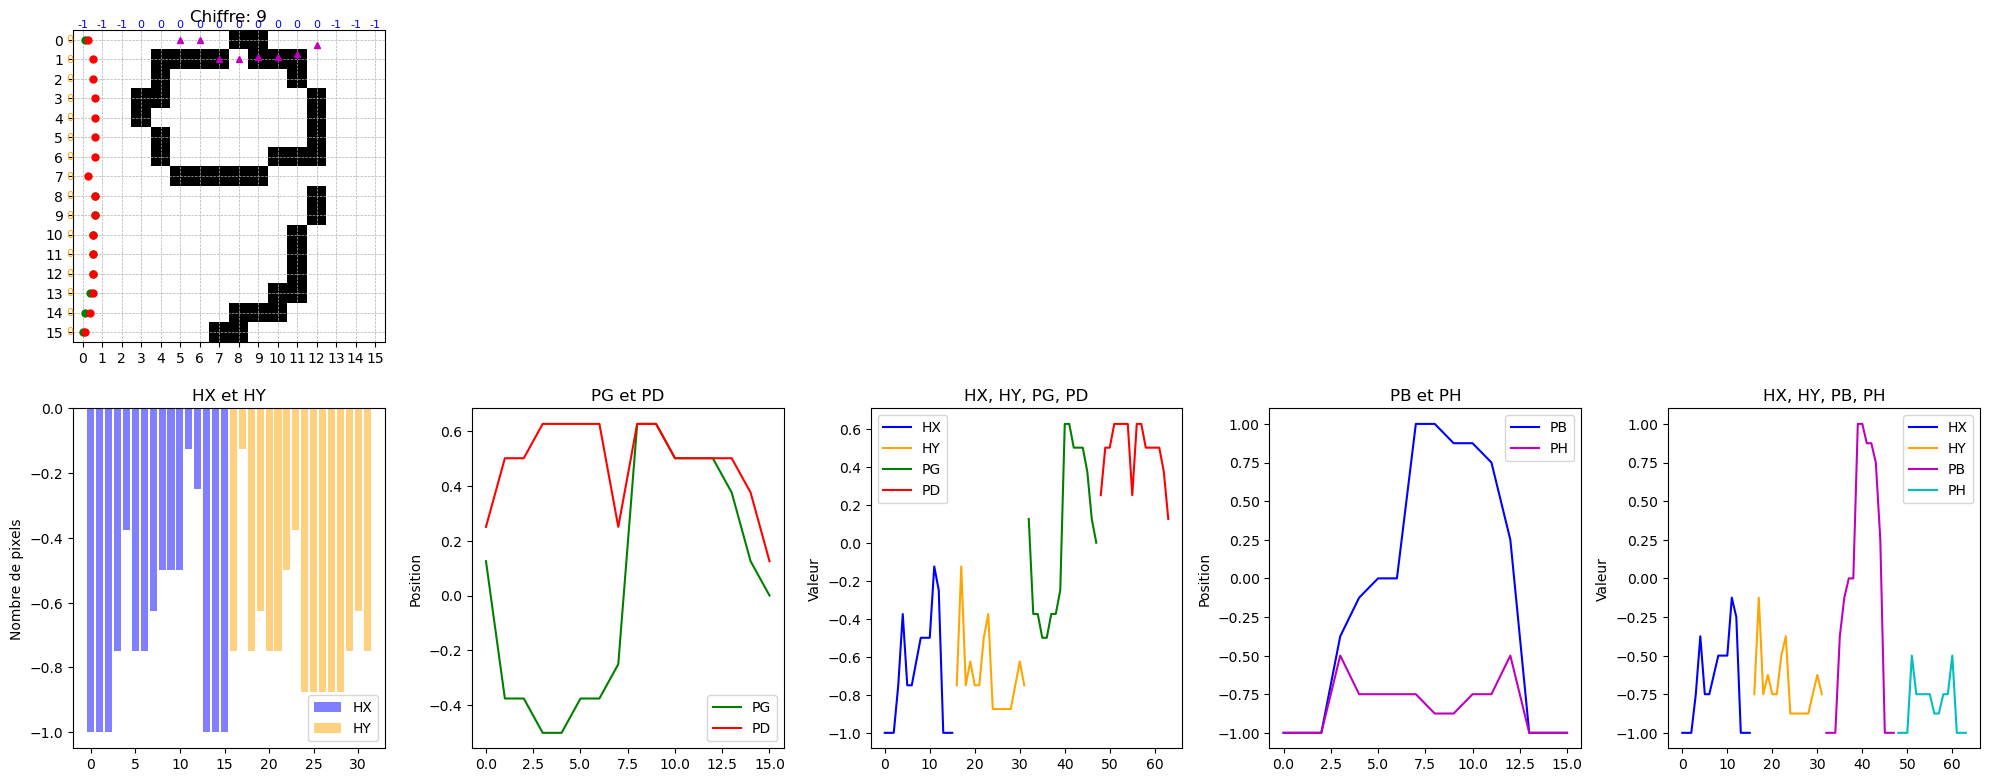

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os

def load_data(x_file: str, t_file: str, coding_files: dict = None):
    """
    Charge les données des fichiers d'entrée et des fichiers de codages.

    Args:
        x_file (str): Chemin vers le fichier x.txt (images 16x16 sous forme de vecteurs 256).
        t_file (str): Chemin vers le fichier t.txt (étiquettes des chiffres).
        coding_files (dict): Dictionnaire des chemins vers les fichiers de codages.

    Returns:
        X (np.ndarray): Matrice des images (256 x 480).
        y (np.ndarray): Vecteur des étiquettes (480,).
        codings (dict): Dictionnaire des codages chargés.
    """
    try:
        X = np.loadtxt(x_file)
        y = np.loadtxt(t_file)  # Charger y sans conversion one-hot par défaut
        codings = {}
        if coding_files:
            for coding_name, file_path in coding_files.items():
                codings[coding_name] = np.loadtxt(file_path)
        return X, y, codings
    except FileNotFoundError as e:
        print(f"Erreur : Fichier '{e.filename}' introuvable.")
        return None, None, None

def display_digit_and_codings(index: int, X_data: np.ndarray, y_data: np.ndarray, codings: dict):
    """
    Affiche une image de chiffre manuscrit avec ses codages superposés et des graphiques séparés.

    Args:
        index (int): Index de l'image à afficher (0 à 479).
        X_data (np.ndarray): Matrice des images (256 x 480).
        y_data (np.ndarray): Vecteur des étiquettes (480,).
        codings (dict): Dictionnaire des codages (ex: {'hx_hy': np.ndarray}).
    """
    if X_data is None or y_data is None or index < 0 or index >= X_data.shape[1]:
        print("Erreur : Données invalides ou index hors limites.")
        return

    # Reshape de l'image en 16x16
    digit = X_data[:, index].reshape(16, 16)

    # Création de la figure principale avec une grille 2x5
    plt.figure(figsize=(20, 8))

    # 1. Affichage de l'image avec annotations des codages
    plt.subplot(2, 5, 1)
    plt.imshow(digit, cmap='binary', interpolation='nearest')
    plt.title(f"Chiffre: {int(y_data[index])}" if y_data[index].ndim == 0 else f"Chiffre: {np.argmax(y_data[index])}")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(np.arange(0, 16, 1))
    plt.yticks(np.arange(0, 16, 1))

    # Superposition des codages sur l'image
    if 'hx_hy' in codings:
        hx = codings['hx_hy'][:16, index]  # Histogramme X
        hy = codings['hx_hy'][16:32, index]  # Histogramme Y
        # Afficher HX comme texte au-dessus de chaque colonne
        for i, val in enumerate(hx):
            plt.text(i, -0.5, f"{int(val)}", ha='center', va='bottom', fontsize=8, color='blue')
        # Afficher HY comme texte à gauche de chaque ligne
        for i, val in enumerate(hy):
            plt.text(-0.5, i, f"{int(val)}", ha='right', va='center', fontsize=8, color='orange')

    if 'pg_pd' in codings:
        pg = codings['pg_pd'][:16, index]  # Profil gauche
        pd = codings['pg_pd'][16:32, index]  # Profil droit
        # Marquer PG (première transition à gauche) avec des cercles verts
        for i, val in enumerate(pg):
            if val >= 0:  # Vérifier que la transition existe
                plt.plot(val, i, 'go', markersize=5)
        # Marquer PD (première transition à droite) avec des cercles rouges
        for i, val in enumerate(pd):
            if val >= 0:  # Vérifier que la transition existe
                plt.plot(val, i, 'ro', markersize=5)

    if 'pb_ph' in codings:
        pb = codings['pb_ph'][:16, index]  # Profil bas
        ph = codings['pb_ph'][16:32, index]  # Profil haut
        # Marquer PH (première transition en haut) avec des triangles bleus
        for i, val in enumerate(ph):
            if val >= 0:
                plt.plot(i, val, 'b^', markersize=5)
        # Marquer PB (première transition en bas) avec des triangles magenta
        for i, val in enumerate(pb):
            if val >= 0:
                plt.plot(i, val, 'm^', markersize=5)

    # 2. Affichage des codages sous forme de graphiques séparés
    coding_names = ['hx_hy', 'pg_pd', 'hx_hy_pg_pd', 'pb_ph', 'hx_hy_pb_ph']
    for i, coding_name in enumerate(coding_names, start=1):  # Commencer à 1 pour les indices
        if coding_name in codings:
            coding = codings[coding_name][:, index]
            plt.subplot(2, 5, i + 5)  # Deuxième ligne : indices 6 à 10

            if coding_name == 'hx_hy':
                plt.bar(range(16), coding[:16], color='blue', alpha=0.5, label='HX')
                plt.bar(range(16, 32), coding[16:], color='orange', alpha=0.5, label='HY')
                plt.title('HX et HY')
                plt.ylabel('Nombre de pixels')  # Désignation réelle
                plt.legend()

            elif coding_name == 'pg_pd':
                plt.plot(range(16), coding[:16], 'g-', label='PG')
                plt.plot(range(16), coding[16:], 'r-', label='PD')
                plt.title('PG et PD')
                plt.ylabel('Position')  # Désignation réelle
                plt.legend()

            elif coding_name == 'hx_hy_pg_pd':
                plt.plot(range(16), coding[:16], 'b-', label='HX')
                plt.plot(range(16, 32), coding[16:32], 'orange', label='HY')
                plt.plot(range(32, 48), coding[32:48], 'g-', label='PG')
                plt.plot(range(48, 64), coding[48:], 'r-', label='PD')
                plt.title('HX, HY, PG, PD')
                plt.ylabel('Valeur')  # Désignation générale pour combinaison
                plt.legend()

            elif coding_name == 'pb_ph':
                plt.plot(range(16), coding[:16], 'b-', label='PB')
                plt.plot(range(16), coding[16:], 'm-', label='PH')
                plt.title('PB et PH')
                plt.ylabel('Position')  # Désignation réelle
                plt.legend()

            elif coding_name == 'hx_hy_pb_ph':
                plt.plot(range(16), coding[:16], 'b-', label='HX')
                plt.plot(range(16, 32), coding[16:32], 'orange', label='HY')
                plt.plot(range(32, 48), coding[32:48], 'm-', label='PB')
                plt.plot(range(48, 64), coding[48:], 'c-', label='PH')
                plt.title('HX, HY, PB, PH')
                plt.ylabel('Valeur')  # Désignation générale pour combinaison
                plt.legend()

    plt.tight_layout()
    plt.show()

# --- Partie Principale du Script ---
if __name__ == "__main__":
    dir_data = './donnees/'

    # Chemins des fichiers de codages
    coding_files = {
        'hx_hy': dir_data + 'hx_hy.txt',
        'pg_pd': dir_data + 'pg_pd.txt',
        'hx_hy_pg_pd': dir_data + 'hx_hy_pg_pd.txt',
        'pb_ph': dir_data + 'pb_ph.txt',
        'hx_hy_pb_ph': dir_data + 'hx_hy_pb_ph.txt'
    }

    # Chargement des données
    X_data, y_data, codings = load_data(dir_data + "x.txt", dir_data + "t.txt", coding_files)

    if X_data is not None and y_data is not None:
        print(f"X_data shape: {X_data.shape}")
        print(f"y_data shape: {y_data.shape}")
        for coding_name, coding_data in codings.items():
            print(f"{coding_name} shape: {coding_data.shape}")

        # Visualisation pour les images de 0 à 9
        for idx in range(10):
            display_digit_and_codings(idx, X_data, y_data, codings)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [34]:
def split_dataset(X, y, test_size=0.15, val_size=0.15, random_state=42):
    """
    Divise les données en ensembles d'entraînement, de test et de validation.

    Args:
        X (np.ndarray): Matrice des codings concaténés (échantillons x caractéristiques).
        y (np.ndarray): Vecteur des étiquettes.
        test_size (float): Proportion pour l'ensemble de test.
        val_size (float): Proportion pour l'ensemble de validation.
        random_state (int): Graine pour la reproductibilité.

    Returns:
        X_train, X_test, X_val, y_train, y_test, y_val.
    """
    # Première division : sépare train+val (85%) et test (15%)
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    # - X_test: Sous-ensemble de test avec 15% des échantillons (e.g., 72 sur 480), contient les caractéristiques des codings pour évaluation finale.
    # - y_test: Étiquettes correspondantes à X_test, utilisées pour mesurer la précision sur le test.
    # - X_temp: Sous-ensemble temporaire contenant train+val (85%, e.g., 408 échantillons).
    # - y_temp: Étiquettes correspondantes à X_temp.

    # Seconde division : sépare train (70% total, ~82% de 85%) et val (15% total, ~18% de 85%) à partir de X_temp
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size/(1-test_size), random_state=random_state)
    # - X_train: Sous-ensemble d'entraînement avec ~70% des échantillons totaux (e.g., 336 sur 480), utilisé pour entraîner le modèle.
    # - y_train: Étiquettes correspondantes à X_train, cible pour l'apprentissage.
    # - X_val: Sous-ensemble de validation avec ~15% des échantillons totaux (e.g., 72 sur 480), utilisé pour ajuster les hyperparamètres.
    # - y_val: Étiquettes correspondantes à X_val, pour évaluer pendant l'ajustement.

    return X_train, X_test, X_val, y_train, y_test, y_val

HxHy

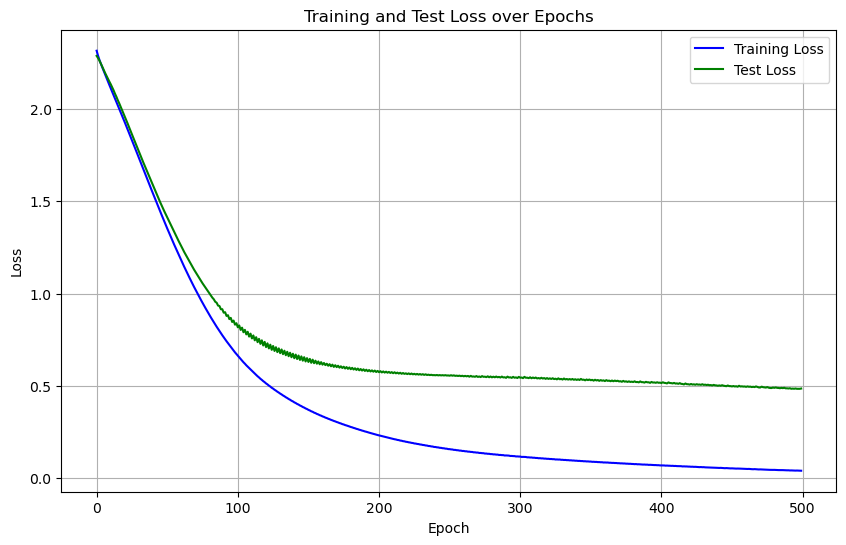

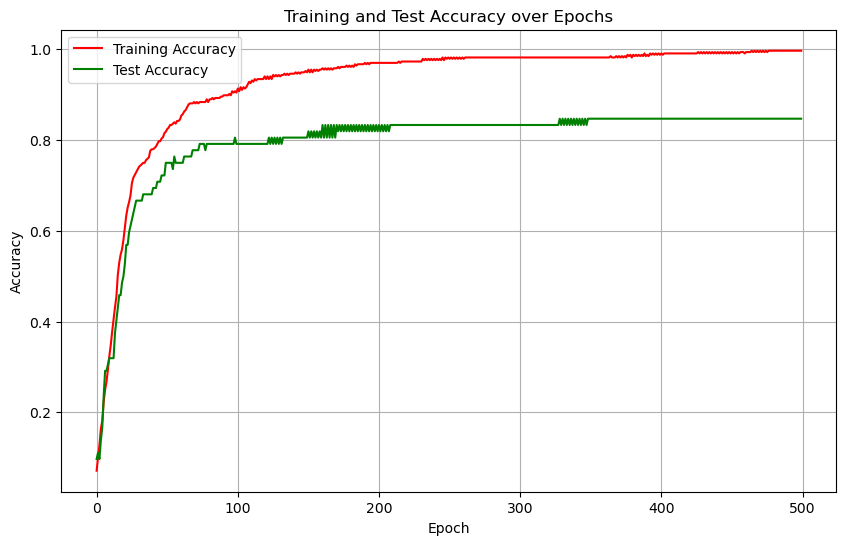

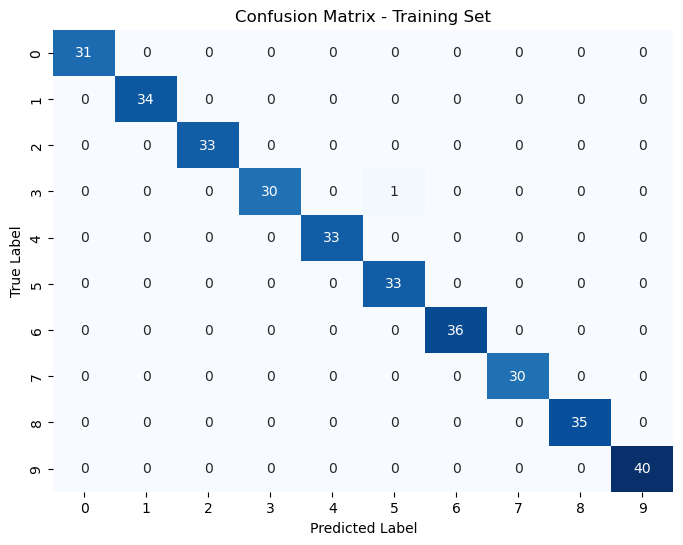

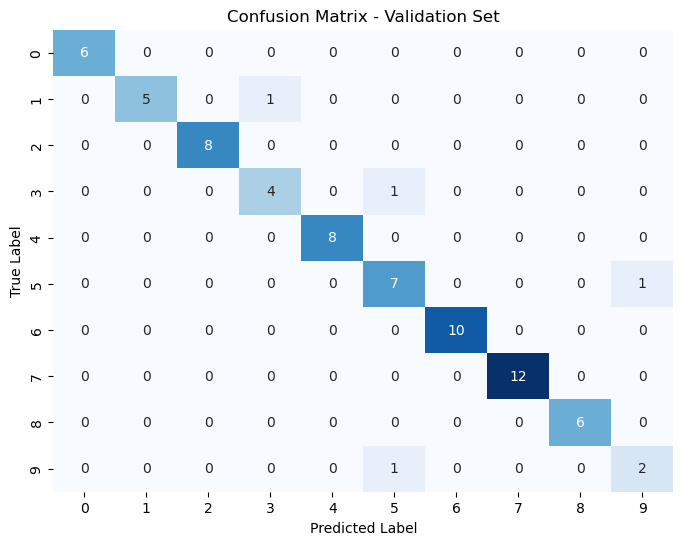

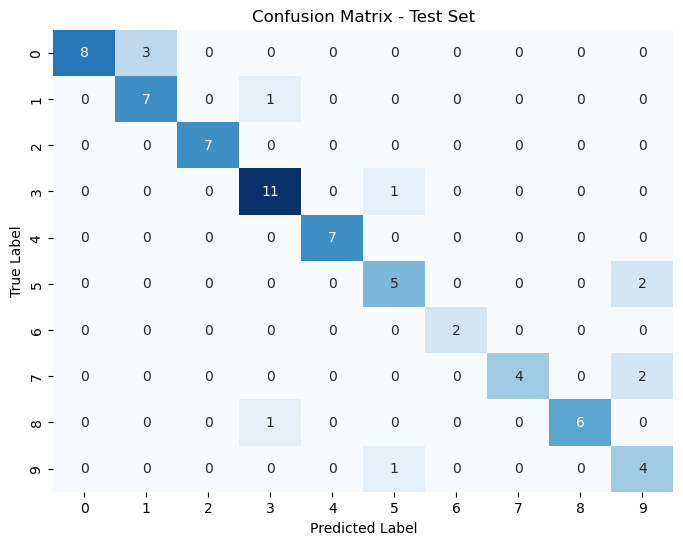

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings
import seaborn as sns  # For better confusion matrix visualization

# Supprimer les avertissements
warnings.filterwarnings("ignore")

def split_dataset(X, y, test_size=0.15, val_size=0.15, random_state=42):
    """
    Divise les données en ensembles d'entraînement, de test et de validation.

    Args:
        X (np.ndarray): Matrice des codings (échantillons x caractéristiques).
        y (np.ndarray): Vecteur des étiquettes.
        test_size (float): Proportion pour l'ensemble de test.
        val_size (float): Proportion pour l'ensemble de validation.
        random_state (int): Graine pour la reproductibilité.

    Returns:
        X_train, X_test, X_val, y_train, y_test, y_val.
    """
    if X.shape[0] != y.shape[0]:
        raise ValueError(f"Inconsistent number of samples: X has {X.shape[0]}, y has {y.shape[0]}")
   
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size/(1-test_size), random_state=random_state)
   
    return X_train, X_test, X_val, y_train, y_test, y_val

def compute_cross_entropy_loss(y_true, y_pred_proba):
    """
    Calcule la perte de cross-entropy manuellement.
    
    Args:
        y_true (np.ndarray): Vraies étiquettes (shape: (n_samples,)).
        y_pred_proba (np.ndarray): Probabilités prédites (shape: (n_samples, n_classes)).
    
    Returns:
        float: Valeur de la perte de cross-entropy.
    """
    n_samples = y_true.shape[0]
    y_true_one_hot = np.zeros(y_pred_proba.shape)
    y_true_one_hot[np.arange(n_samples), y_true] = 1
    return -np.mean(np.sum(y_true_one_hot * np.log(y_pred_proba + 1e-15), axis=1))  # Ajout de 1e-15 pour éviter log(0)

# --- Partie Principale du Script ---
if __name__ == "__main__":
    # Définir le chemin du fichier
    dir_data = './donnees/'
    hx_hy_file = dir_data + 'hx_hy.txt'

    # Charger et inspecter les données
    y_raw = np.loadtxt(dir_data + 't.txt')
   
    if y_raw.shape[0] == 10 and y_raw.shape[1] == 480:  # Si (10, 480), transposer
        y = y_raw.T
    else:
        y = y_raw  # Garder tel quel si déjà correct
   
    if y.ndim > 1 and y.shape[1] == 10:  # Si one-hot (480, 10)
        y = np.argmax(y, axis=1)  # Convertir en (480,)
   
    X = np.loadtxt(hx_hy_file).T  # Chargement de hx_hy.txt, transposition pour (480, 32)

    # Appliquer la fonction de split
    X_train, X_test, X_val, y_train, y_test, y_val = split_dataset(X, y, test_size=0.15, val_size=0.15, random_state=42)

    # Entraînement d'un Multilayer Perceptron (MLP) avec suivi de la perte et de l'exactitude
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1, warm_start=True, random_state=42, verbose=False)
    n_epochs = 500  # Nombre total d'itérations
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    test_losses = []

    for epoch in range(n_epochs):
        mlp.fit(X_train, y_train)  # Entraîner une itération à la fois
        # Calculer la perte et l'exactitude sur l'entraînement
        train_loss = mlp.loss_
        train_losses.append(train_loss)
        train_accuracy = mlp.score(X_train, y_train)
        train_accuracies.append(train_accuracy)
        # Calculer l'exactitude sur le test
        test_accuracy = mlp.score(X_test, y_test)
        test_accuracies.append(test_accuracy)
        # Calculer la perte sur le test
        y_test_pred_proba = mlp.predict_proba(X_test)
        test_loss = compute_cross_entropy_loss(y_test, y_test_pred_proba)
        test_losses.append(test_loss)

    # Prédictions pour les matrices de confusion
    y_train_pred = mlp.predict(X_train)  # Prédiction sur l'ensemble d'entraînement
    y_val_pred = mlp.predict(X_val)
    y_test_pred = mlp.predict(X_test)

    # Calcul des matrices de confusion
    train_cm = confusion_matrix(y_train, y_train_pred)
    val_cm = confusion_matrix(y_val, y_val_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)

    # Visualisation des figures
    epochs = range(n_epochs)

    # Figure pour la perte (entraînement et test)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, test_losses, 'g-', label='Test Loss')
    plt.title('Training and Test Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure pour l'exactitude (entraînement et test)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, 'r-', label='Training Accuracy')
    plt.plot(epochs, test_accuracies, 'g-', label='Test Accuracy')
    plt.title('Training and Test Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure pour la matrice de confusion de l'entraînement
    plt.figure(figsize=(8, 6))
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Training Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Figure pour la matrice de confusion de validation
    plt.figure(figsize=(8, 6))
    sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Validation Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Figure pour la matrice de confusion de test
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Test Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

pb_ph

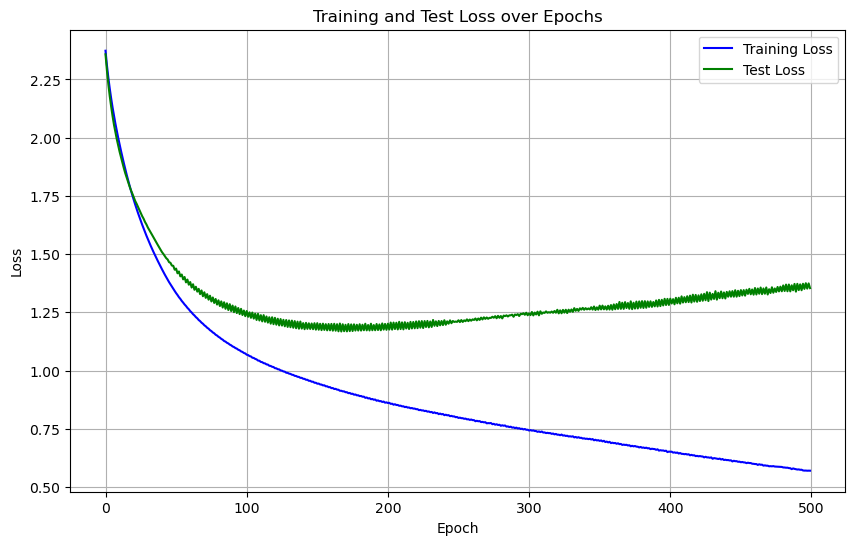

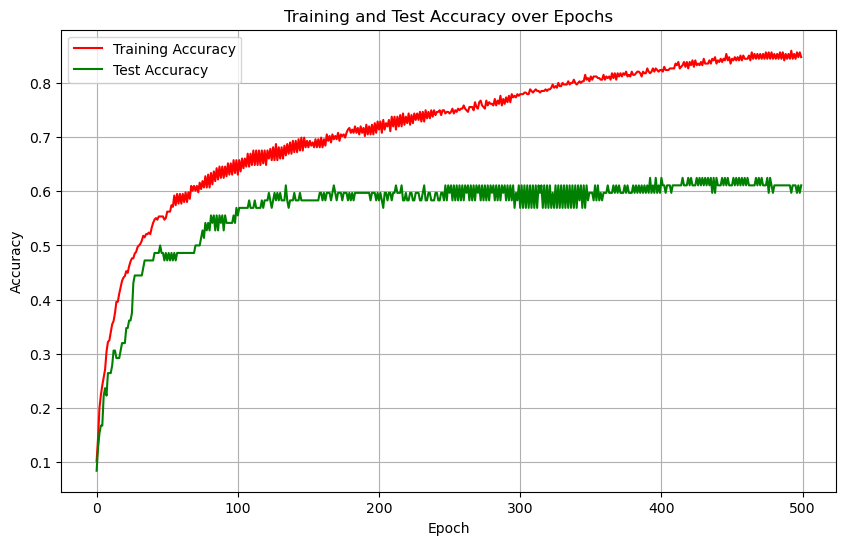

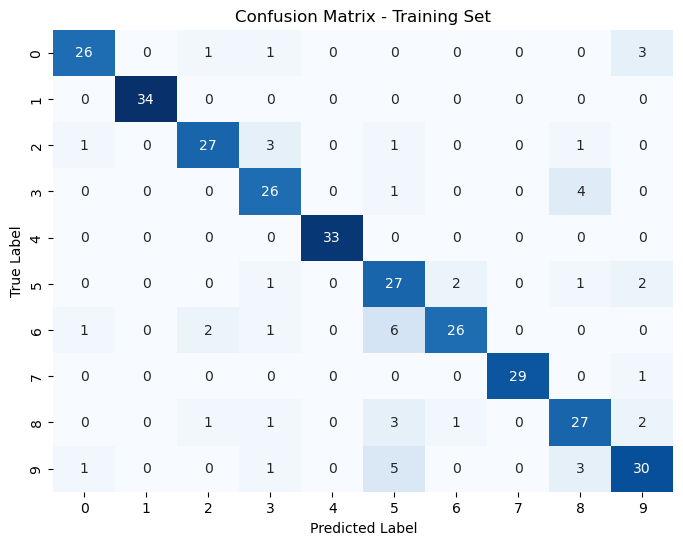

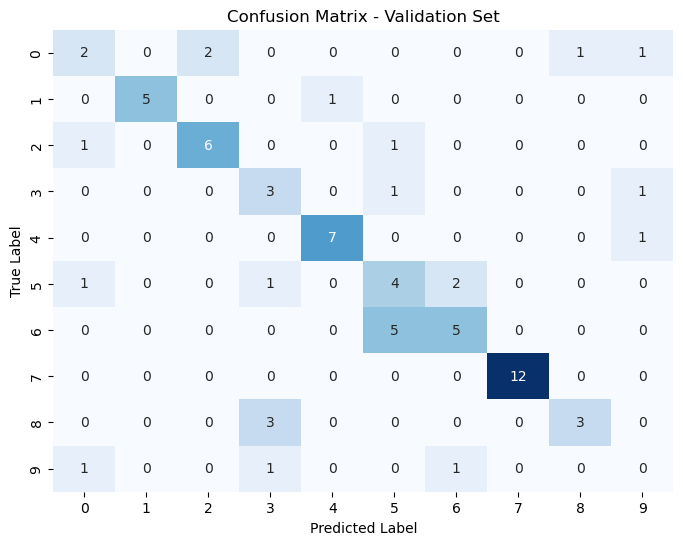

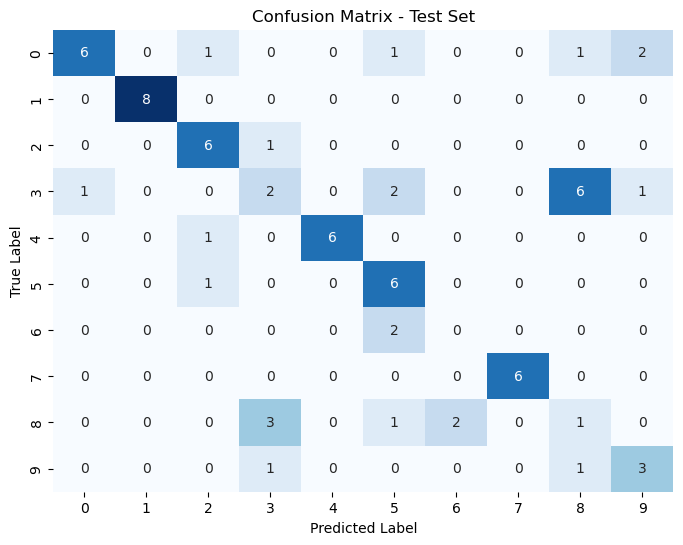

In [46]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings
import seaborn as sns  # For better confusion matrix visualization

# Supprimer les avertissements
warnings.filterwarnings("ignore")

def split_dataset(X, y, test_size=0.15, val_size=0.15, random_state=42):
    """
    Divise les données en ensembles d'entraînement, de test et de validation.

    Args:
        X (np.ndarray): Matrice des codings (échantillons x caractéristiques).
        y (np.ndarray): Vecteur des étiquettes.
        test_size (float): Proportion pour l'ensemble de test.
        val_size (float): Proportion pour l'ensemble de validation.
        random_state (int): Graine pour la reproductibilité.

    Returns:
        X_train, X_test, X_val, y_train, y_test, y_val.
    """
    if X.shape[0] != y.shape[0]:
        raise ValueError(f"Inconsistent number of samples: X has {X.shape[0]}, y has {y.shape[0]}")
   
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size/(1-test_size), random_state=random_state)
   
    return X_train, X_test, X_val, y_train, y_test, y_val

def compute_cross_entropy_loss(y_true, y_pred_proba):
    """
    Calcule la perte de cross-entropy manuellement.
    
    Args:
        y_true (np.ndarray): Vraies étiquettes (shape: (n_samples,)).
        y_pred_proba (np.ndarray): Probabilités prédites (shape: (n_samples, n_classes)).
    
    Returns:
        float: Valeur de la perte de cross-entropy.
    """
    n_samples = y_true.shape[0]
    y_true_one_hot = np.zeros(y_pred_proba.shape)
    y_true_one_hot[np.arange(n_samples), y_true] = 1
    return -np.mean(np.sum(y_true_one_hot * np.log(y_pred_proba + 1e-15), axis=1))  # Ajout de 1e-15 pour éviter log(0)

# --- Partie Principale du Script ---
if __name__ == "__main__":
    # Définir le chemin du fichier
    dir_data = './donnees/'
    hx_hy_file = dir_data + 'pb_ph.txt'

    # Charger et inspecter les données
    y_raw = np.loadtxt(dir_data + 't.txt')
   
    if y_raw.shape[0] == 10 and y_raw.shape[1] == 480:  # Si (10, 480), transposer
        y = y_raw.T
    else:
        y = y_raw  # Garder tel quel si déjà correct
   
    if y.ndim > 1 and y.shape[1] == 10:  # Si one-hot (480, 10)
        y = np.argmax(y, axis=1)  # Convertir en (480,)
   
    X = np.loadtxt(hx_hy_file).T  # Chargement de hx_hy.txt, transposition pour (480, 32)

    # Appliquer la fonction de split
    X_train, X_test, X_val, y_train, y_test, y_val = split_dataset(X, y, test_size=0.15, val_size=0.15, random_state=42)

    # Entraînement d'un Multilayer Perceptron (MLP) avec suivi de la perte et de l'exactitude
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1, warm_start=True, random_state=42, verbose=False)
    n_epochs = 500  # Nombre total d'itérations
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    test_losses = []

    for epoch in range(n_epochs):
        mlp.fit(X_train, y_train)  # Entraîner une itération à la fois
        # Calculer la perte et l'exactitude sur l'entraînement
        train_loss = mlp.loss_
        train_losses.append(train_loss)
        train_accuracy = mlp.score(X_train, y_train)
        train_accuracies.append(train_accuracy)
        # Calculer l'exactitude sur le test
        test_accuracy = mlp.score(X_test, y_test)
        test_accuracies.append(test_accuracy)
        # Calculer la perte sur le test
        y_test_pred_proba = mlp.predict_proba(X_test)
        test_loss = compute_cross_entropy_loss(y_test, y_test_pred_proba)
        test_losses.append(test_loss)

    # Prédictions pour les matrices de confusion
    y_train_pred = mlp.predict(X_train)  # Prédiction sur l'ensemble d'entraînement
    y_val_pred = mlp.predict(X_val)
    y_test_pred = mlp.predict(X_test)

    # Calcul des matrices de confusion
    train_cm = confusion_matrix(y_train, y_train_pred)
    val_cm = confusion_matrix(y_val, y_val_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)

    # Visualisation des figures
    epochs = range(n_epochs)

    # Figure pour la perte (entraînement et test)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, test_losses, 'g-', label='Test Loss')
    plt.title('Training and Test Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure pour l'exactitude (entraînement et test)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, 'r-', label='Training Accuracy')
    plt.plot(epochs, test_accuracies, 'g-', label='Test Accuracy')
    plt.title('Training and Test Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure pour la matrice de confusion de l'entraînement
    plt.figure(figsize=(8, 6))
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Training Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Figure pour la matrice de confusion de validation
    plt.figure(figsize=(8, 6))
    sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Validation Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Figure pour la matrice de confusion de test
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Test Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

pg_pd

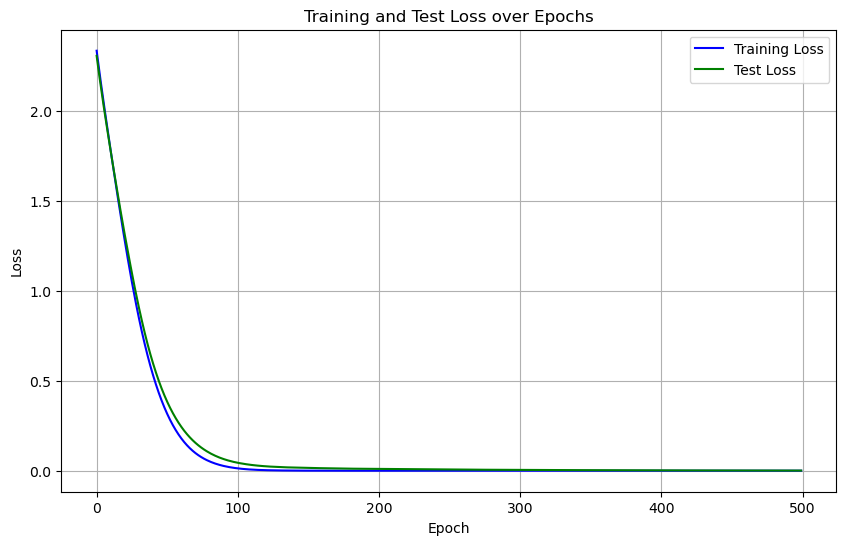

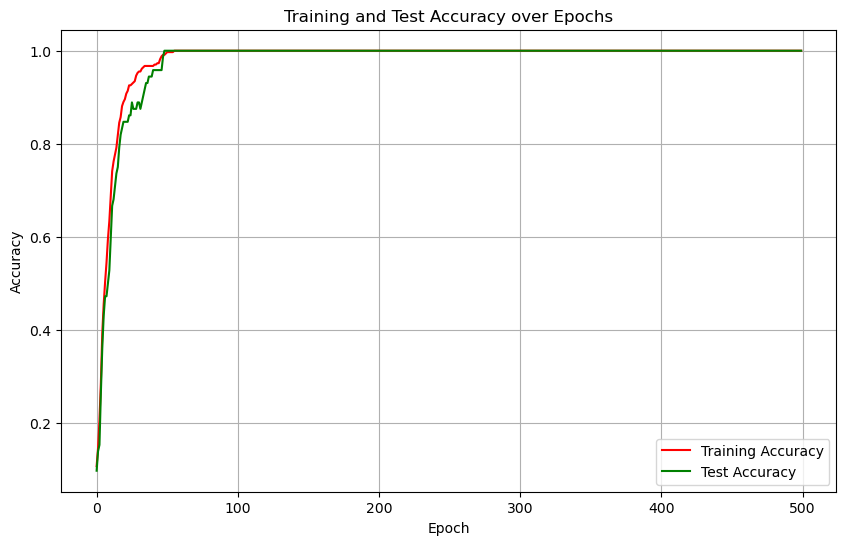

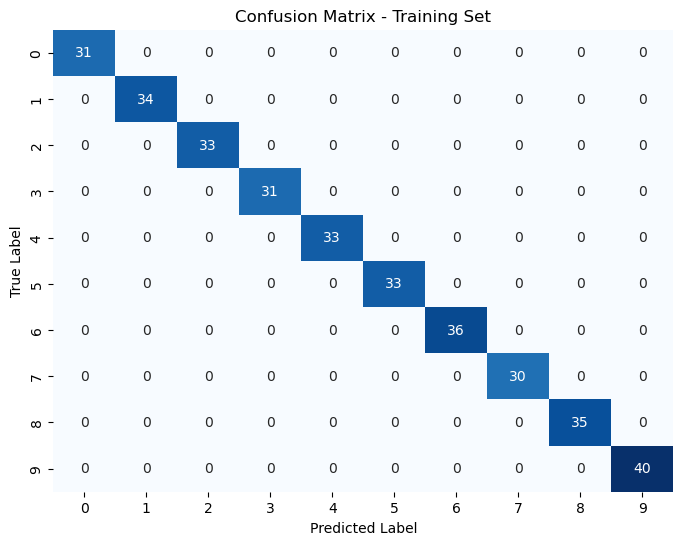

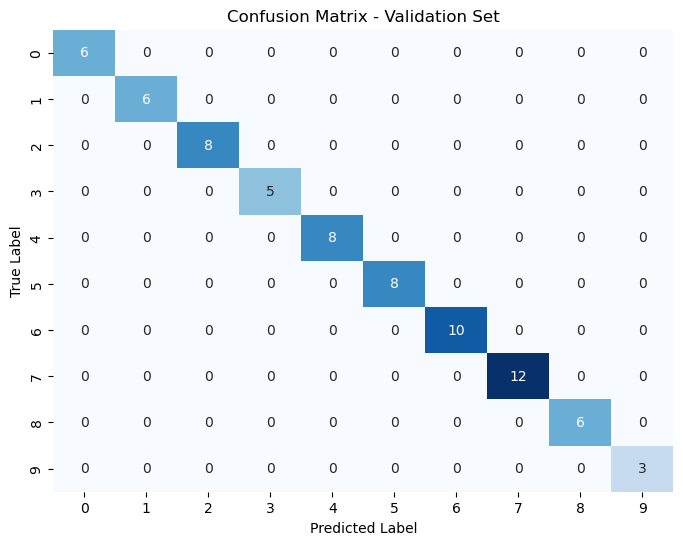

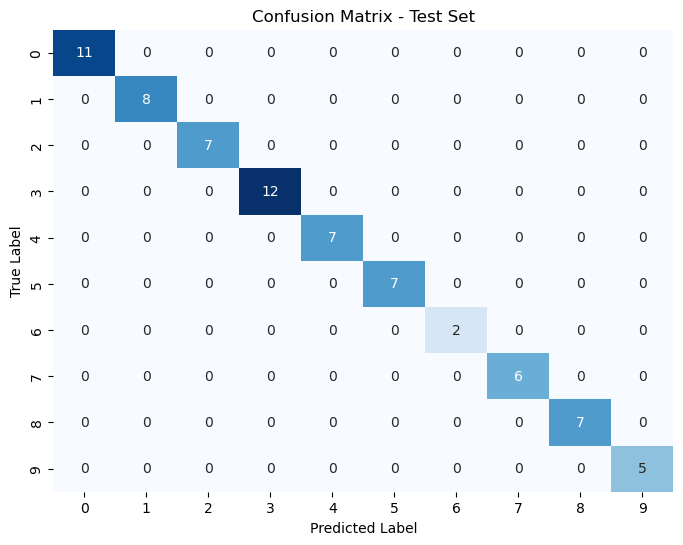

In [47]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings
import seaborn as sns  # For better confusion matrix visualization

# Supprimer les avertissements
warnings.filterwarnings("ignore")

def split_dataset(X, y, test_size=0.15, val_size=0.15, random_state=42):
    """
    Divise les données en ensembles d'entraînement, de test et de validation.

    Args:
        X (np.ndarray): Matrice des codings (échantillons x caractéristiques).
        y (np.ndarray): Vecteur des étiquettes.
        test_size (float): Proportion pour l'ensemble de test.
        val_size (float): Proportion pour l'ensemble de validation.
        random_state (int): Graine pour la reproductibilité.

    Returns:
        X_train, X_test, X_val, y_train, y_test, y_val.
    """
    if X.shape[0] != y.shape[0]:
        raise ValueError(f"Inconsistent number of samples: X has {X.shape[0]}, y has {y.shape[0]}")
   
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size/(1-test_size), random_state=random_state)
   
    return X_train, X_test, X_val, y_train, y_test, y_val

def compute_cross_entropy_loss(y_true, y_pred_proba):
    """
    Calcule la perte de cross-entropy manuellement.
    
    Args:
        y_true (np.ndarray): Vraies étiquettes (shape: (n_samples,)).
        y_pred_proba (np.ndarray): Probabilités prédites (shape: (n_samples, n_classes)).
    
    Returns:
        float: Valeur de la perte de cross-entropy.
    """
    n_samples = y_true.shape[0]
    y_true_one_hot = np.zeros(y_pred_proba.shape)
    y_true_one_hot[np.arange(n_samples), y_true] = 1
    return -np.mean(np.sum(y_true_one_hot * np.log(y_pred_proba + 1e-15), axis=1))  # Ajout de 1e-15 pour éviter log(0)

# --- Partie Principale du Script ---
if __name__ == "__main__":
    # Définir le chemin du fichier
    dir_data = './donnees/'
    hx_hy_file = dir_data + 'pg_pd.txt'

    # Charger et inspecter les données
    y_raw = np.loadtxt(dir_data + 't.txt')
   
    if y_raw.shape[0] == 10 and y_raw.shape[1] == 480:  # Si (10, 480), transposer
        y = y_raw.T
    else:
        y = y_raw  # Garder tel quel si déjà correct
   
    if y.ndim > 1 and y.shape[1] == 10:  # Si one-hot (480, 10)
        y = np.argmax(y, axis=1)  # Convertir en (480,)
   
    X = np.loadtxt(hx_hy_file).T  # Chargement de hx_hy.txt, transposition pour (480, 32)

    # Appliquer la fonction de split
    X_train, X_test, X_val, y_train, y_test, y_val = split_dataset(X, y, test_size=0.15, val_size=0.15, random_state=42)

    # Entraînement d'un Multilayer Perceptron (MLP) avec suivi de la perte et de l'exactitude
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1, warm_start=True, random_state=42, verbose=False)
    n_epochs = 500  # Nombre total d'itérations
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    test_losses = []

    for epoch in range(n_epochs):
        mlp.fit(X_train, y_train)  # Entraîner une itération à la fois
        # Calculer la perte et l'exactitude sur l'entraînement
        train_loss = mlp.loss_
        train_losses.append(train_loss)
        train_accuracy = mlp.score(X_train, y_train)
        train_accuracies.append(train_accuracy)
        # Calculer l'exactitude sur le test
        test_accuracy = mlp.score(X_test, y_test)
        test_accuracies.append(test_accuracy)
        # Calculer la perte sur le test
        y_test_pred_proba = mlp.predict_proba(X_test)
        test_loss = compute_cross_entropy_loss(y_test, y_test_pred_proba)
        test_losses.append(test_loss)

    # Prédictions pour les matrices de confusion
    y_train_pred = mlp.predict(X_train)  # Prédiction sur l'ensemble d'entraînement
    y_val_pred = mlp.predict(X_val)
    y_test_pred = mlp.predict(X_test)

    # Calcul des matrices de confusion
    train_cm = confusion_matrix(y_train, y_train_pred)
    val_cm = confusion_matrix(y_val, y_val_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)

    # Visualisation des figures
    epochs = range(n_epochs)

    # Figure pour la perte (entraînement et test)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, test_losses, 'g-', label='Test Loss')
    plt.title('Training and Test Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure pour l'exactitude (entraînement et test)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, 'r-', label='Training Accuracy')
    plt.plot(epochs, test_accuracies, 'g-', label='Test Accuracy')
    plt.title('Training and Test Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure pour la matrice de confusion de l'entraînement
    plt.figure(figsize=(8, 6))
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Training Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Figure pour la matrice de confusion de validation
    plt.figure(figsize=(8, 6))
    sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Validation Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Figure pour la matrice de confusion de test
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Test Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

hx_hy_pb_ph

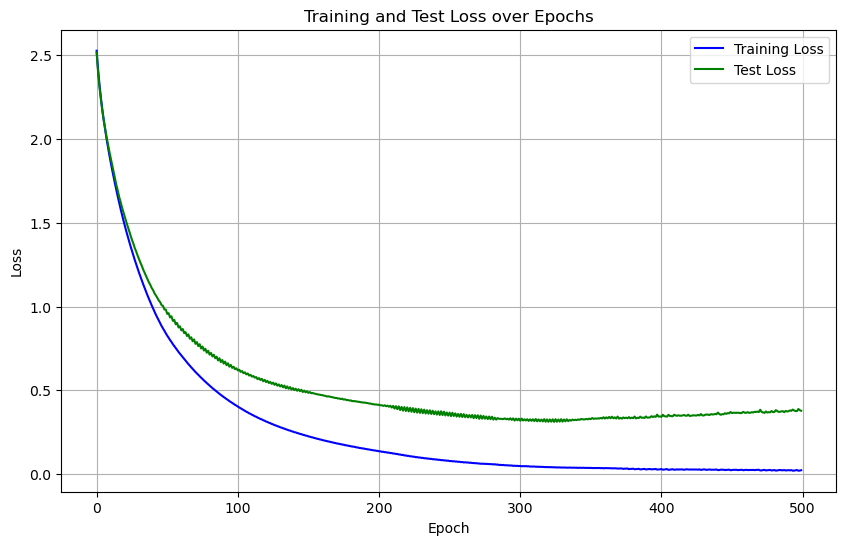

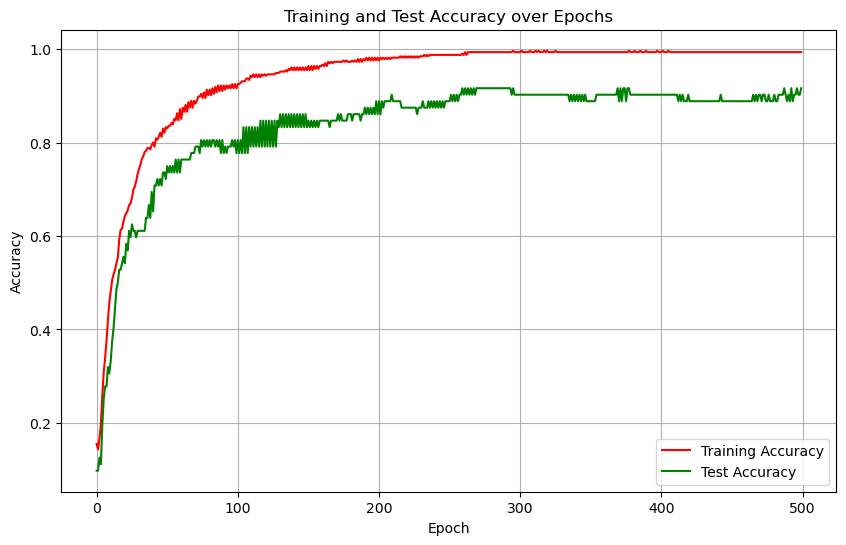

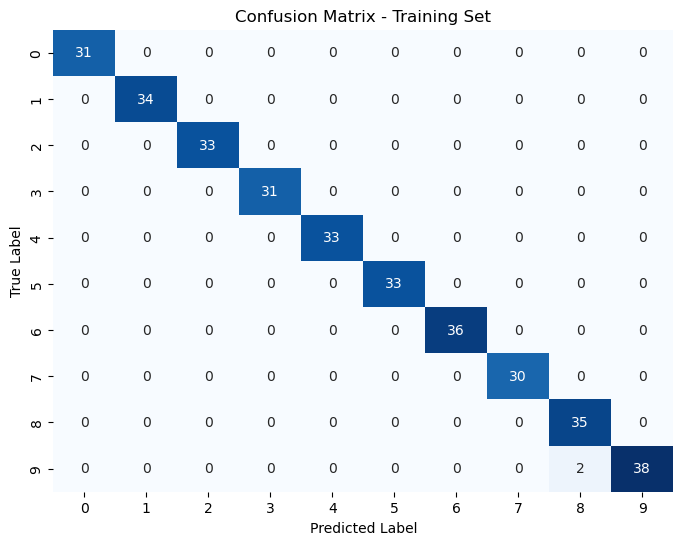

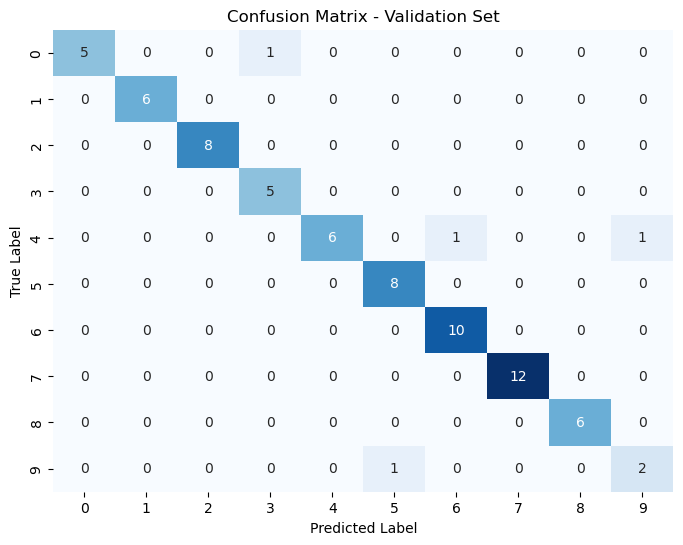

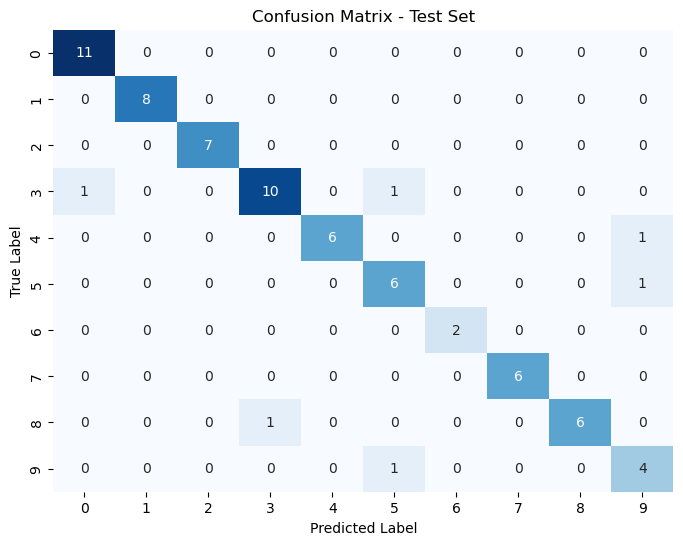

In [48]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings
import seaborn as sns  # For better confusion matrix visualization

# Supprimer les avertissements
warnings.filterwarnings("ignore")

def split_dataset(X, y, test_size=0.15, val_size=0.15, random_state=42):
    """
    Divise les données en ensembles d'entraînement, de test et de validation.

    Args:
        X (np.ndarray): Matrice des codings (échantillons x caractéristiques).
        y (np.ndarray): Vecteur des étiquettes.
        test_size (float): Proportion pour l'ensemble de test.
        val_size (float): Proportion pour l'ensemble de validation.
        random_state (int): Graine pour la reproductibilité.

    Returns:
        X_train, X_test, X_val, y_train, y_test, y_val.
    """
    if X.shape[0] != y.shape[0]:
        raise ValueError(f"Inconsistent number of samples: X has {X.shape[0]}, y has {y.shape[0]}")
   
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size/(1-test_size), random_state=random_state)
   
    return X_train, X_test, X_val, y_train, y_test, y_val

def compute_cross_entropy_loss(y_true, y_pred_proba):
    """
    Calcule la perte de cross-entropy manuellement.
    
    Args:
        y_true (np.ndarray): Vraies étiquettes (shape: (n_samples,)).
        y_pred_proba (np.ndarray): Probabilités prédites (shape: (n_samples, n_classes)).
    
    Returns:
        float: Valeur de la perte de cross-entropy.
    """
    n_samples = y_true.shape[0]
    y_true_one_hot = np.zeros(y_pred_proba.shape)
    y_true_one_hot[np.arange(n_samples), y_true] = 1
    return -np.mean(np.sum(y_true_one_hot * np.log(y_pred_proba + 1e-15), axis=1))  # Ajout de 1e-15 pour éviter log(0)

# --- Partie Principale du Script ---
if __name__ == "__main__":
    # Définir le chemin du fichier
    dir_data = './donnees/'
    hx_hy_file = dir_data + 'hx_hy_pb_ph.txt'

    # Charger et inspecter les données
    y_raw = np.loadtxt(dir_data + 't.txt')
   
    if y_raw.shape[0] == 10 and y_raw.shape[1] == 480:  # Si (10, 480), transposer
        y = y_raw.T
    else:
        y = y_raw  # Garder tel quel si déjà correct
   
    if y.ndim > 1 and y.shape[1] == 10:  # Si one-hot (480, 10)
        y = np.argmax(y, axis=1)  # Convertir en (480,)
   
    X = np.loadtxt(hx_hy_file).T  # Chargement de hx_hy.txt, transposition pour (480, 32)

    # Appliquer la fonction de split
    X_train, X_test, X_val, y_train, y_test, y_val = split_dataset(X, y, test_size=0.15, val_size=0.15, random_state=42)

    # Entraînement d'un Multilayer Perceptron (MLP) avec suivi de la perte et de l'exactitude
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1, warm_start=True, random_state=42, verbose=False)
    n_epochs = 500  # Nombre total d'itérations
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    test_losses = []

    for epoch in range(n_epochs):
        mlp.fit(X_train, y_train)  # Entraîner une itération à la fois
        # Calculer la perte et l'exactitude sur l'entraînement
        train_loss = mlp.loss_
        train_losses.append(train_loss)
        train_accuracy = mlp.score(X_train, y_train)
        train_accuracies.append(train_accuracy)
        # Calculer l'exactitude sur le test
        test_accuracy = mlp.score(X_test, y_test)
        test_accuracies.append(test_accuracy)
        # Calculer la perte sur le test
        y_test_pred_proba = mlp.predict_proba(X_test)
        test_loss = compute_cross_entropy_loss(y_test, y_test_pred_proba)
        test_losses.append(test_loss)

    # Prédictions pour les matrices de confusion
    y_train_pred = mlp.predict(X_train)  # Prédiction sur l'ensemble d'entraînement
    y_val_pred = mlp.predict(X_val)
    y_test_pred = mlp.predict(X_test)

    # Calcul des matrices de confusion
    train_cm = confusion_matrix(y_train, y_train_pred)
    val_cm = confusion_matrix(y_val, y_val_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)

    # Visualisation des figures
    epochs = range(n_epochs)

    # Figure pour la perte (entraînement et test)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, test_losses, 'g-', label='Test Loss')
    plt.title('Training and Test Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure pour l'exactitude (entraînement et test)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, 'r-', label='Training Accuracy')
    plt.plot(epochs, test_accuracies, 'g-', label='Test Accuracy')
    plt.title('Training and Test Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure pour la matrice de confusion de l'entraînement
    plt.figure(figsize=(8, 6))
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Training Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Figure pour la matrice de confusion de validation
    plt.figure(figsize=(8, 6))
    sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Validation Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Figure pour la matrice de confusion de test
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Test Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

hx_hy_pg_pd

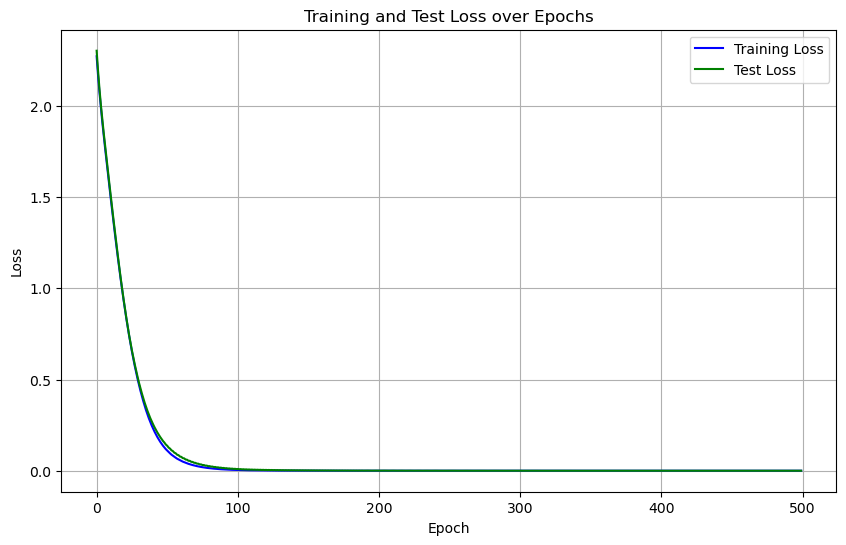

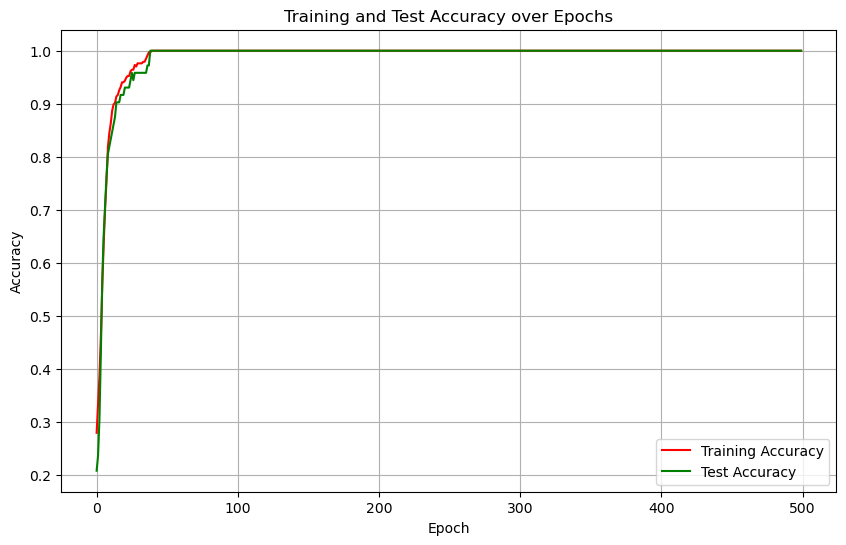

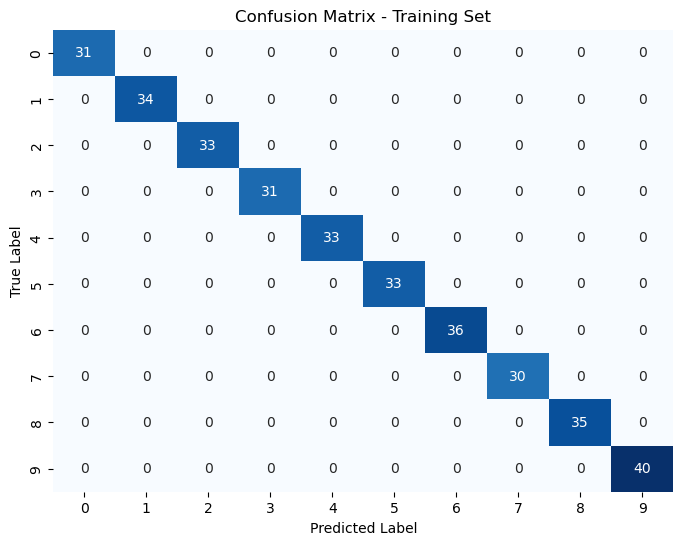

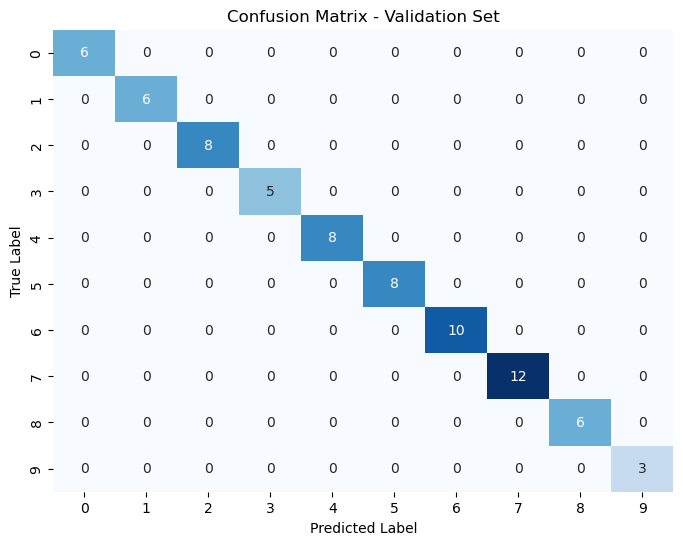

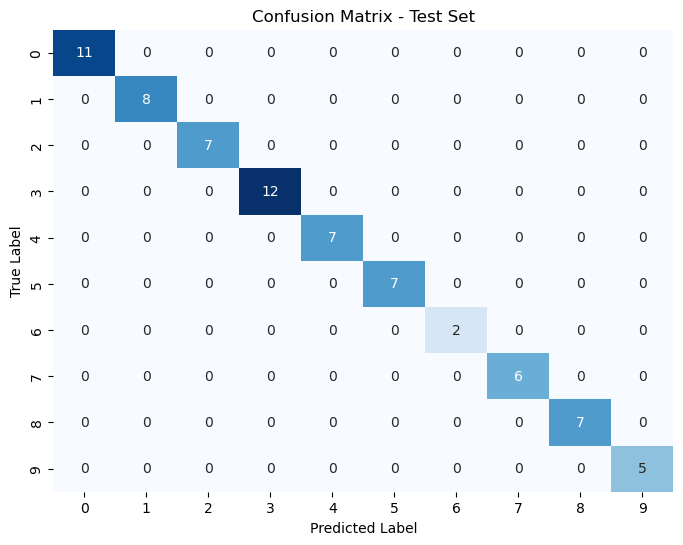

In [49]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings
import seaborn as sns  # For better confusion matrix visualization

# Supprimer les avertissements
warnings.filterwarnings("ignore")

def split_dataset(X, y, test_size=0.15, val_size=0.15, random_state=42):
    """
    Divise les données en ensembles d'entraînement, de test et de validation.

    Args:
        X (np.ndarray): Matrice des codings (échantillons x caractéristiques).
        y (np.ndarray): Vecteur des étiquettes.
        test_size (float): Proportion pour l'ensemble de test.
        val_size (float): Proportion pour l'ensemble de validation.
        random_state (int): Graine pour la reproductibilité.

    Returns:
        X_train, X_test, X_val, y_train, y_test, y_val.
    """
    if X.shape[0] != y.shape[0]:
        raise ValueError(f"Inconsistent number of samples: X has {X.shape[0]}, y has {y.shape[0]}")
   
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size/(1-test_size), random_state=random_state)
   
    return X_train, X_test, X_val, y_train, y_test, y_val

def compute_cross_entropy_loss(y_true, y_pred_proba):
    """
    Calcule la perte de cross-entropy manuellement.
    
    Args:
        y_true (np.ndarray): Vraies étiquettes (shape: (n_samples,)).
        y_pred_proba (np.ndarray): Probabilités prédites (shape: (n_samples, n_classes)).
    
    Returns:
        float: Valeur de la perte de cross-entropy.
    """
    n_samples = y_true.shape[0]
    y_true_one_hot = np.zeros(y_pred_proba.shape)
    y_true_one_hot[np.arange(n_samples), y_true] = 1
    return -np.mean(np.sum(y_true_one_hot * np.log(y_pred_proba + 1e-15), axis=1))  # Ajout de 1e-15 pour éviter log(0)

# --- Partie Principale du Script ---
if __name__ == "__main__":
    # Définir le chemin du fichier
    dir_data = './donnees/'
    hx_hy_file = dir_data + 'hx_hy_pg_pd.txt'

    # Charger et inspecter les données
    y_raw = np.loadtxt(dir_data + 't.txt')
   
    if y_raw.shape[0] == 10 and y_raw.shape[1] == 480:  # Si (10, 480), transposer
        y = y_raw.T
    else:
        y = y_raw  # Garder tel quel si déjà correct
   
    if y.ndim > 1 and y.shape[1] == 10:  # Si one-hot (480, 10)
        y = np.argmax(y, axis=1)  # Convertir en (480,)
   
    X = np.loadtxt(hx_hy_file).T  # Chargement de hx_hy.txt, transposition pour (480, 32)

    # Appliquer la fonction de split
    X_train, X_test, X_val, y_train, y_test, y_val = split_dataset(X, y, test_size=0.15, val_size=0.15, random_state=42)

    # Entraînement d'un Multilayer Perceptron (MLP) avec suivi de la perte et de l'exactitude
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1, warm_start=True, random_state=42, verbose=False)
    n_epochs = 500  # Nombre total d'itérations
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    test_losses = []

    for epoch in range(n_epochs):
        mlp.fit(X_train, y_train)  # Entraîner une itération à la fois
        # Calculer la perte et l'exactitude sur l'entraînement
        train_loss = mlp.loss_
        train_losses.append(train_loss)
        train_accuracy = mlp.score(X_train, y_train)
        train_accuracies.append(train_accuracy)
        # Calculer l'exactitude sur le test
        test_accuracy = mlp.score(X_test, y_test)
        test_accuracies.append(test_accuracy)
        # Calculer la perte sur le test
        y_test_pred_proba = mlp.predict_proba(X_test)
        test_loss = compute_cross_entropy_loss(y_test, y_test_pred_proba)
        test_losses.append(test_loss)

    # Prédictions pour les matrices de confusion
    y_train_pred = mlp.predict(X_train)  # Prédiction sur l'ensemble d'entraînement
    y_val_pred = mlp.predict(X_val)
    y_test_pred = mlp.predict(X_test)

    # Calcul des matrices de confusion
    train_cm = confusion_matrix(y_train, y_train_pred)
    val_cm = confusion_matrix(y_val, y_val_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)

    # Visualisation des figures
    epochs = range(n_epochs)

    # Figure pour la perte (entraînement et test)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, test_losses, 'g-', label='Test Loss')
    plt.title('Training and Test Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure pour l'exactitude (entraînement et test)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, 'r-', label='Training Accuracy')
    plt.plot(epochs, test_accuracies, 'g-', label='Test Accuracy')
    plt.title('Training and Test Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure pour la matrice de confusion de l'entraînement
    plt.figure(figsize=(8, 6))
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Training Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Figure pour la matrice de confusion de validation
    plt.figure(figsize=(8, 6))
    sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Validation Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Figure pour la matrice de confusion de test
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Test Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()